In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 1 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/n

In [2]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] =False

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import matplotlib.ticker as ticker
import numpy as np
import glob

# 공통 함수 정의

In [4]:
def clean_numeric_columns(df, cols):
    for c in cols:
        if c in df.columns:
            df[c] = (
                df[c]
                .astype(str)
                .str.replace(',', '', regex=False)
            )
            df[c] = pd.to_numeric(df[c], errors='coerce').fillna(0)
    return df


def add_operation_flags(df, cols):
    df['결항여부'] = (df[cols].sum(axis=1) == 0).astype(int)
    df['운항여부'] = 1 - df['결항여부']
    return df


def classify_daytype(date, is_holiday):
    if is_holiday:
        return "공휴일"
    if date.weekday() >= 5:
        return "주말"
    return "주중"



## 일별 여객 출항

In [5]:
#데이터 불러오기
df_p_out = pd.read_csv("일별 여객 출항.csv")
print(df_p_out.dtypes)

출항일    object
대인     object
중고      int64
경로      int64
소아      int64
편승      int64
합계     object
유아      int64
임시      int64
dtype: object


In [6]:
#날짜 처리 및 기본 전처리
df_p_out['출항일'] = pd.to_datetime(df_p_out['출항일'])
df_p_out['연도'] = df_p_out['출항일'].dt.year
df_p_out['월'] = df_p_out['출항일'].dt.month

#합계-> 숫자형으로 변환
df_p_out['합계'] = df_p_out['합계'].astype(str).str.replace(',','')

In [7]:
#column fix
cols_fix = ['대인','중고','경로','소아','편승', '합계','유아','임시']
for c in cols_fix:
    #문자열로 변환 후 쉼표 제거
    df_p_out[c] = df_p_out[c].astype(str).str.replace(',','', regex =False)
    #숫자형으로 변환
    df_p_out[c] = pd.to_numeric(df_p_out[c])

print(df_p_out.dtypes)

출항일    datetime64[ns]
대인              int64
중고              int64
경로              int64
소아              int64
편승              int64
합계              int64
유아              int64
임시              int64
연도              int32
월               int32
dtype: object


In [8]:
# Define num_cols
num_cols = ['대인', '중고', '경로', '소아', '편승', '합계', '유아', '임시']

#for c in num_cols:
    #df_p_out[c] = pd.to_numeric(df_p_out[c], errors='coerce').fillna(0)

    # 출항일을 컬럼 이름으로 사용
print(c, df_p_out[df_p_out[c] < 0][['출항일', c]])

임시 Empty DataFrame
Columns: [출항일, 임시]
Index: []


In [9]:
#음수 값 처리
df_p_out[num_cols] = df_p_out[num_cols].clip(lower=0)

## 연도별 월간 여객 추이 그래프

In [10]:
#연도별 월간 여객 추이 그래프
monthly = df_p_out.groupby(['연도', '월'])['합계'].sum().reset_index()

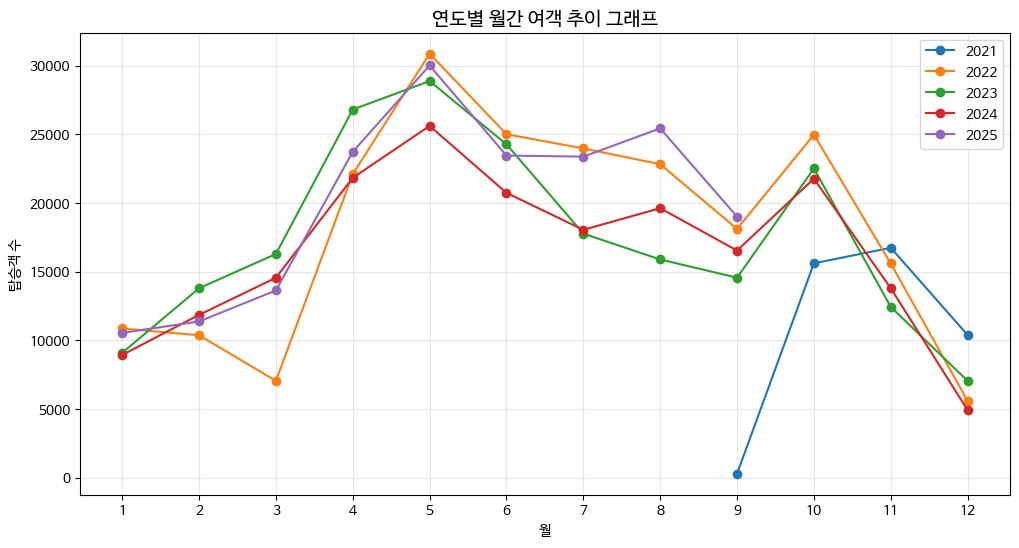

In [11]:
#그래프 그리기

plt.figure(figsize=(12,6))

for year in sorted(monthly['연도'].unique()):
  subset = monthly[monthly['연도'] == year]
  plt.plot(subset['월'], subset['합계'], marker='o', label = f'{year}')

plt.title("연도별 월간 여객 추이 그래프", fontsize =14)
plt.xlabel('월')
plt.ylabel('탑승객 수')
plt.xticks(range(1,13))
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 연령대별 합계 계산

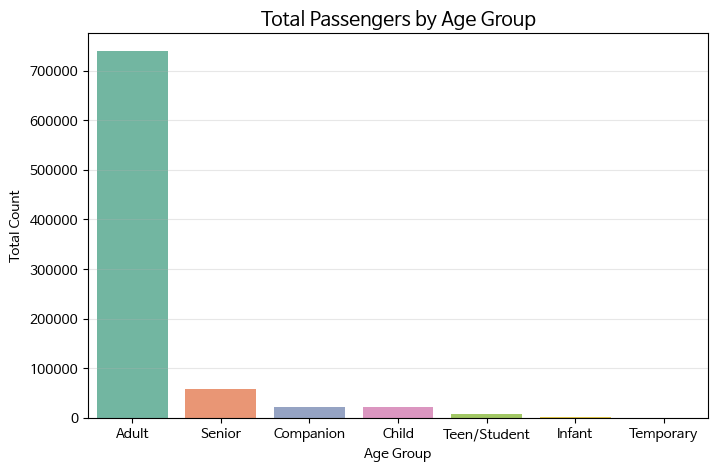

In [12]:
#연령대별 합계 계산
age_labels = {
    '대인': 'Adult',
    '중고': 'Teen/Student',
    '경로': 'Senior',
    '소아': 'Child',
    '편승': 'Companion',
    '유아': 'Infant',
    '임시': 'Temporary'
}
age_sum = df_p_out[list(age_labels.keys())].sum().sort_values(ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x=[age_labels[a] for a in age_sum.index], y=age_sum.values, hue=[age_labels[a] for a in age_sum.index], palette ='Set2', legend=False)
plt.title('Total Passengers by Age Group', fontsize =14)
plt.ylabel('Total Count')
plt.xlabel('Age Group')
plt.grid(axis='y', alpha=0.3)
plt.show()

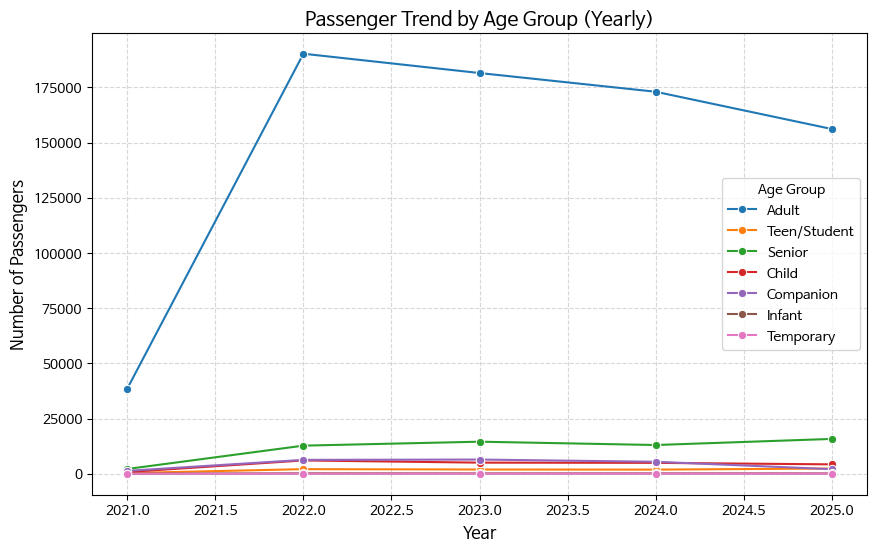

In [13]:
df_p_out['출항일'] = pd.to_datetime(df_p_out['출항일'])
df_p_out['Year'] = df_p_out['출항일'].dt.year

age_yearly = df_p_out.groupby('Year')[list(age_labels.keys())].sum().reset_index()
age_melt = age_yearly.melt(id_vars='Year', var_name='Age Group (KR)', value_name='Passengers')
age_melt['Age Group'] = age_melt['Age Group (KR)'].map(age_labels)

plt.figure(figsize=(10,6))
sns.lineplot(data=age_melt, x='Year', y='Passengers', hue='Age Group', marker='o')
plt.title('Passenger Trend by Age Group (Yearly)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Passengers', fontsize=12)
plt.legend(title='Age Group')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

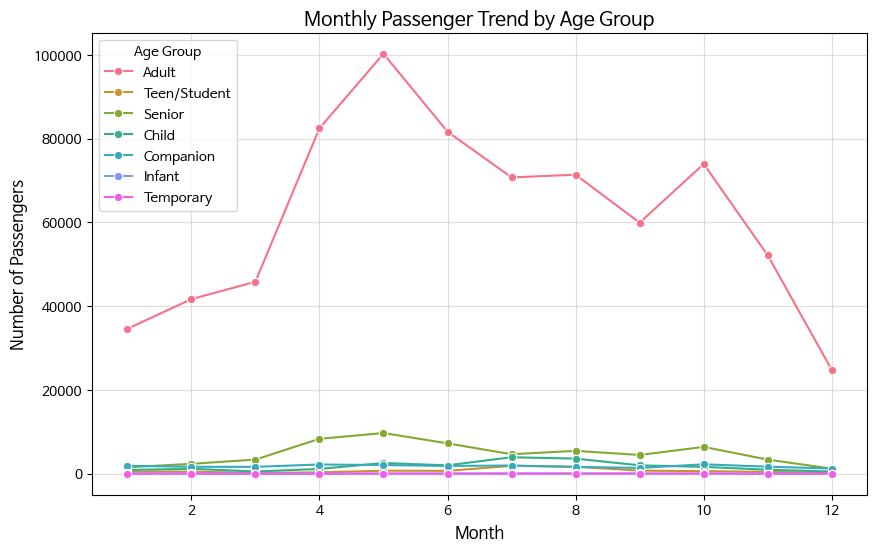

In [14]:
df_p_out['Month'] = df_p_out['출항일'].dt.month
age_monthly = df_p_out.groupby('Month')[list(age_labels.keys())].sum().reset_index()
age_monthly_melt = age_monthly.melt(id_vars='Month', var_name='Age Group (KR)', value_name='Passengers')
age_monthly_melt['Age Group'] = age_monthly_melt['Age Group (KR)'].map(age_labels)

plt.figure(figsize=(10,6))
sns.lineplot(data=age_monthly_melt, x='Month', y='Passengers', hue='Age Group', marker='o', palette='husl')
plt.title('Monthly Passenger Trend by Age Group', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Passengers', fontsize=12)
plt.legend(title='Age Group')
plt.grid(True, alpha=0.4)
plt.show()

##**비수기**/**성수기**

In [15]:
# 모든 월을 포함하고 있는 연도 (2022~2024) 기준 월별 평균 계산

complete_years = [2022, 2023, 2024]
base_avg = (
    monthly[monthly['연도'].isin(complete_years)]
    .groupby('월')['합계']
    .mean()
    .rename('Base_Avg')
    .reset_index()
)

# 3. 전체 Year-Month 틀 생성 및 기존 데이터 merge

start = monthly['연도'].min()
end = monthly['연도'].max()

year_month_index = pd.date_range(
    start=f'{start}-01-01',
    end=f'{end}-12-01',
    freq='MS'
)

full = pd.DataFrame({'YearMonth': year_month_index})
full['연도'] = full['YearMonth'].dt.year
full['월'] = full['YearMonth'].dt.month

full = full.merge(monthly, on=['연도', '월'], how='left')

# 4. 누락값 보간

full = full.merge(base_avg, on='월', how='left')
full['합계'] = full['합계'].fillna(full['Base_Avg'])

# 5. 보간된 데이터 기준 월별 평균 및 성수기 판단

# 월별 평균 계산
monthly_avg = full.groupby('월')['합계'].mean().reset_index()
monthly_avg.rename(columns={'합계': 'Imputed_Avg'}, inplace=True)

# 전체 평균 계산 (이 값이 곧 Threshold)
overall_avg = monthly_avg['Imputed_Avg'].mean()
threshold = overall_avg

# 성수기 / 비수기 구분: 평균보다 크면 성수기
monthly_avg['Season'] = monthly_avg['Imputed_Avg'].apply(
    lambda x: '성수기' if x > threshold else '비수기'
)


=== 성수기 판단 기준 (전체 평균) ===
전체 평균/성수기 기준: 17,341

=== 월별 성수기/비수기 결과 ===
     월   Imputed_Avg Season
4    5  28762.600000    성수기
3    4  23608.733333    성수기
5    6  23361.533333    성수기
9   10  21590.333333    성수기
7    8  20642.000000    성수기
6    7  20620.466667    성수기
10  11  14502.866667    비수기
8    9  13705.000000    비수기
2    3  12833.066667    비수기
1    2  11881.533333    비수기
0    1   9815.466667    비수기
11  12   6764.400000    비수기


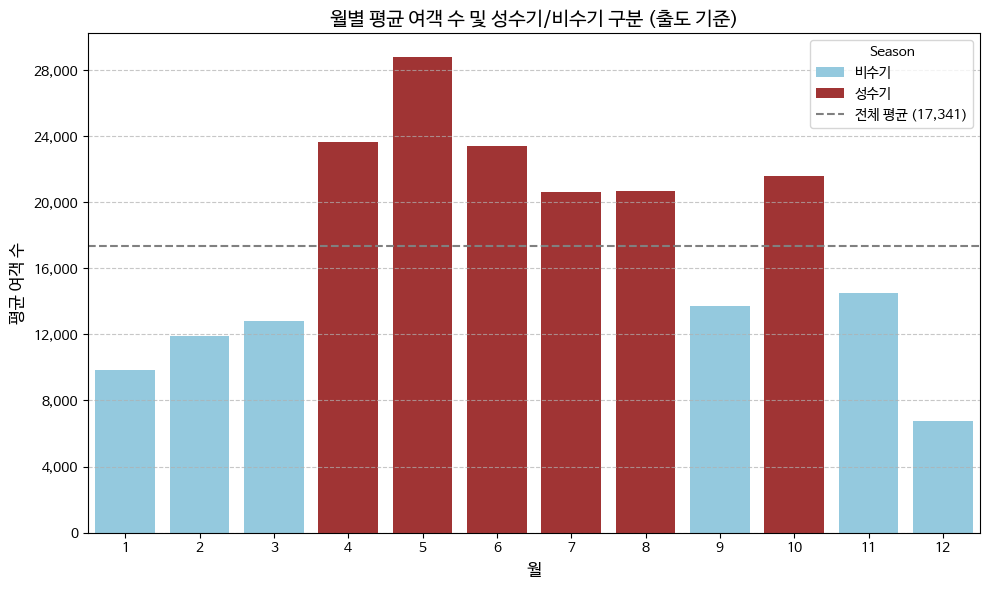

In [16]:
# 6. 결과 출력

print("\n=== 성수기 판단 기준 (전체 평균) ===")
print(f"전체 평균/성수기 기준: {overall_avg:,.0f}")

print("\n=== 월별 성수기/비수기 결과 ===")
print(monthly_avg.sort_values('Imputed_Avg', ascending=False))

# EDA Plot: 월별 평균 여객 수 시각화

# X축 라벨링을 위해 Month를 문자열로 변환
monthly_avg['Month_str'] = monthly_avg['월'].astype(str)

# Figure와 Axes 생성
fig, ax = plt.subplots(figsize=(10, 6))

# Bar Plot 그리기
sns.barplot(
    data=monthly_avg,
    x='Month_str',
    y='Imputed_Avg',
    hue='Season',
    palette={'성수기': 'firebrick', '비수기': 'skyblue'},
    ax=ax,
    dodge=False
)

# 전체 평균선 표시
ax.axhline(
    overall_avg,
    color='gray',
    linestyle='--',
    linewidth=1.5,
    label=f'전체 평균 ({overall_avg:,.0f})'
)

# 성수기 임계치선은 overall_avg와 동일하므로 별도로 표시하지 않음

# 제목 및 축 레이블 설정
ax.set_title('월별 평균 여객 수 및 성수기/비수기 구분 (출도 기준)', fontsize=14)
ax.set_xlabel('월', fontsize=12)
ax.set_ylabel('평균 여객 수', fontsize=12)

# Y축 숫자 포맷팅 (천 단위 쉼표)
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x):,}"))

# 범례 위치 지정
ax.legend(title='Season', loc='upper right')

# y축 그리드 추가
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# 입항 데이터

In [17]:
# 데이터 불러오기
df_in_p = pd.read_csv('일별 여객 입항.csv')

In [18]:
# 데이터 전처리
df_in_p.rename(columns={'출항일': '날짜'}, inplace=True)
df_in_p['날짜'] = pd.to_datetime(df_in_p['날짜'], errors='coerce')
df_in_p = df_in_p.dropna(subset=['날짜'])

# 연도 / 월
df_in_p['Year'] = df_in_p['날짜'].dt.year
df_in_p['Month'] = df_in_p['날짜'].dt.month

# Passenger count numeric conversion
df_in_p['합계'] = (
    df_in_p['합계'].astype(str)
    .str.replace(',', '', regex=False)
    .astype(float)
)

# Age columns
age_cols = ['대인', '중고', '경로', '소아', '편승', '유아', '임시']
for c in age_cols:
    df_in_p[c] = df_in_p[c].astype(str).str.replace(',', '')
    df_in_p[c] = pd.to_numeric(df_in_p[c], errors='coerce')

/tmp/ipython-input-735897687.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


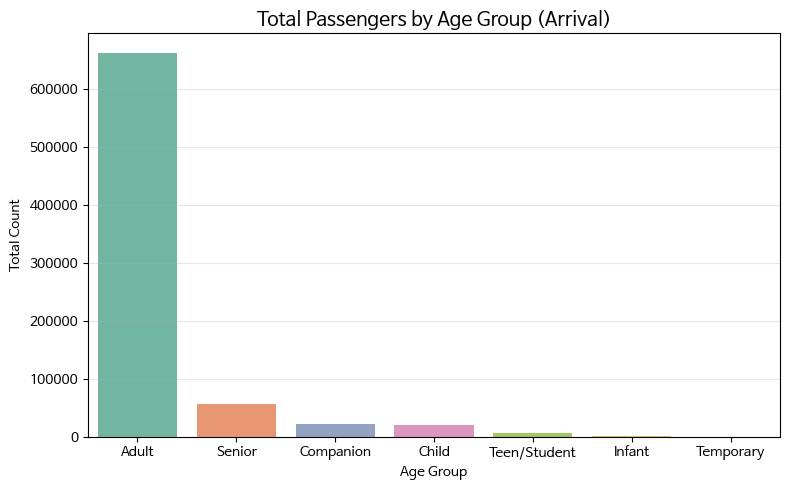

In [19]:
# Age label mapping
age_label_map = {
    '대인': 'Adult',
    '중고': 'Teen/Student',
    '경로': 'Senior',
    '소아': 'Child',
    '편승': 'Companion',
    '유아': 'Infant',
    '임시': 'Temporary'
}

# 전체 연령대 합계
age_sum = df_in_p[age_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(
    x=[age_label_map[a] for a in age_sum.index],
    y=age_sum.values,
    palette='Set2'
)
plt.title('Total Passengers by Age Group (Arrival)', fontsize=14)
plt.ylabel('Total Count')
plt.xlabel('Age Group')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

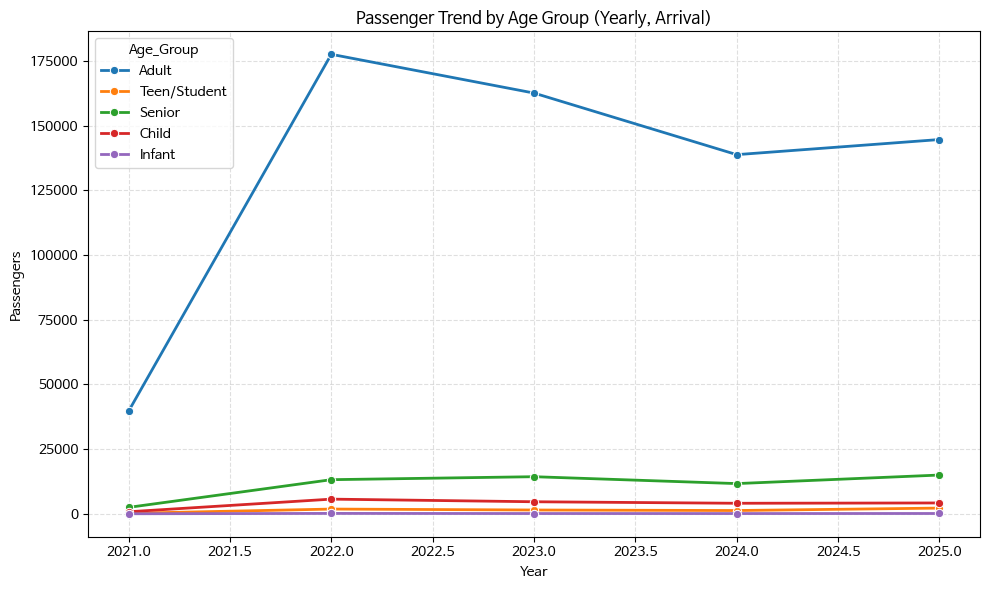

In [20]:
# 연도별 추이
age_cols_main = ['대인', '중고', '경로', '소아', '유아']
age_label_main = {k: age_label_map[k] for k in age_cols_main}

age_year = df_in_p.groupby('Year')[age_cols_main].sum().reset_index()
melt_age = age_year.melt(id_vars='Year', var_name='Age_KR', value_name='Passengers')
melt_age['Age_Group'] = melt_age['Age_KR'].map(age_label_main)

plt.figure(figsize=(10,6))
sns.lineplot(
    data=melt_age,
    x='Year', y='Passengers', hue='Age_Group',
    marker='o', linewidth=2
)
plt.title('Passenger Trend by Age Group (Yearly, Arrival)')
plt.xlabel('Year')
plt.ylabel('Passengers')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

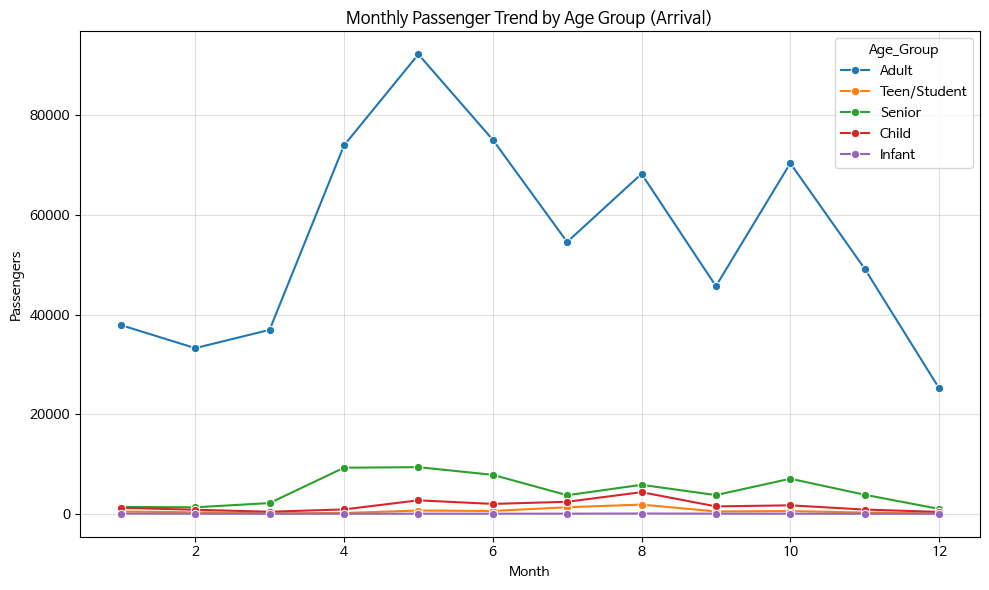

In [21]:
# 월별 연령대 추이
age_month = df_in_p.groupby('Month')[age_cols_main].sum().reset_index()
melt_age_m = age_month.melt(id_vars='Month', var_name='Age_KR', value_name='Passengers')
melt_age_m['Age_Group'] = melt_age_m['Age_KR'].map(age_label_main)

plt.figure(figsize=(10,6))
sns.lineplot(
    data=melt_age_m,
    x='Month', y='Passengers', hue='Age_Group',
    marker='o'
)
plt.title('Monthly Passenger Trend by Age Group (Arrival)')
plt.xlabel('Month')
plt.ylabel('Passengers')
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()

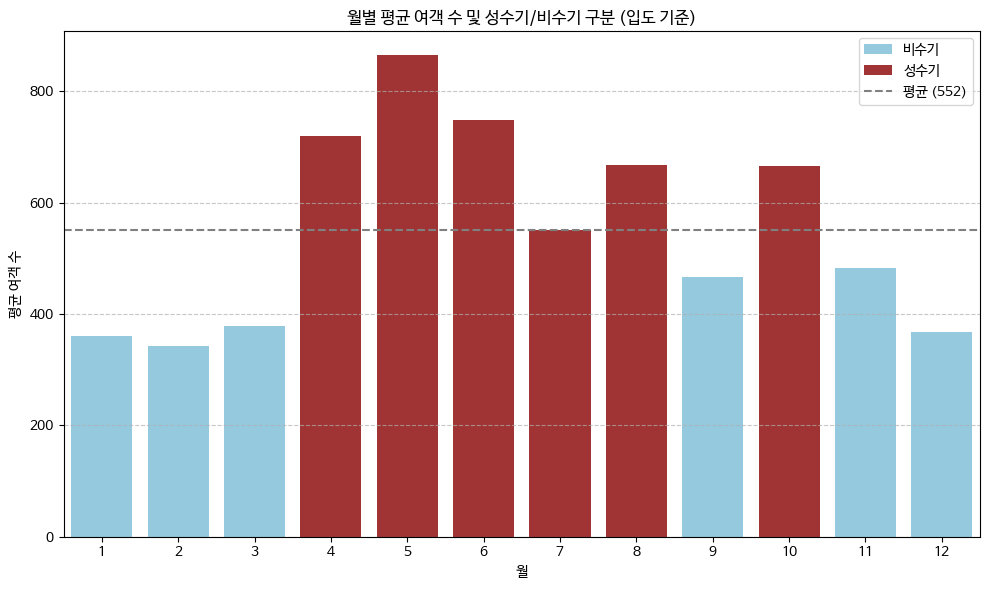

In [22]:
#월별 성수기/비수기 시즌 비교

monthly_avg = df_in_p.groupby('Month')['합계'].mean().reset_index()
overall_avg = monthly_avg['합계'].mean()

# 시즌 정의
monthly_avg['Season'] = monthly_avg['합계'].apply(
    lambda x: '성수기' if x > overall_avg else '비수기'
)

plt.figure(figsize=(10,6))
sns.barplot(
    data=monthly_avg,
    x='Month', y='합계', hue='Season',
    palette={'성수기': 'firebrick', '비수기': 'skyblue'},
    dodge=False
)
plt.axhline(overall_avg, color='gray', linestyle='--', label=f'평균 ({overall_avg:.0f})')
plt.title('월별 평균 여객 수 및 성수기/비수기 구분 (입도 기준)')
plt.xlabel('월')
plt.ylabel('평균 여객 수')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


/tmp/ipython-input-634321834.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_cancel_avg, x='Month', y='Avg_No_Sail_Days', palette='Reds')


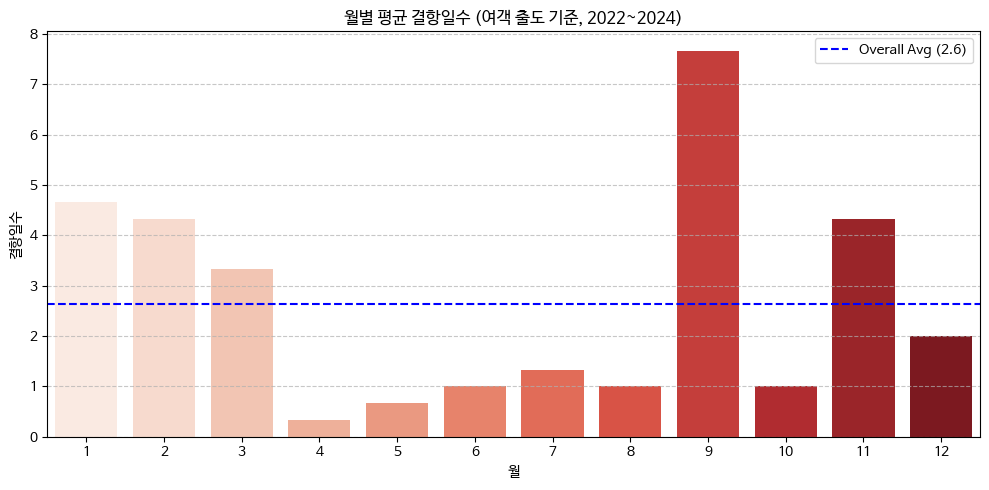

In [23]:
passenger_cols = ['합계', '대인', '중고', '경로', '소아', '편승', '유아', '임시']
df_in_p['결항여부'] = (df_in_p[passenger_cols].sum(axis=1) == 0).astype(int)
df_in_p['운항여부'] = 1 - df_in_p['결항여부']

# 1. 월별 결항일수 계산
df_in_p['Year'] = df_in_p['날짜'].dt.year
df_in_p['Month'] = df_in_p['날짜'].dt.month

monthly_cancel = df_in_p.groupby(['Year','Month'])['결항여부'].sum().reset_index()

# 2. 완전연도 기준 월별 평균 결항일수 (2022~2024)
COMPLETE_YEARS = [2022, 2023, 2024]
monthly_cancel_avg = (
    monthly_cancel[monthly_cancel['Year'].isin(COMPLETE_YEARS)]
    .groupby('Month')['결항여부']
    .mean()
    .reset_index()
    .rename(columns={'결항여부':'Avg_No_Sail_Days'})
)

overall_cancel_avg = monthly_cancel_avg['Avg_No_Sail_Days'].mean()

# 3. 시각화
plt.figure(figsize=(10,5))
sns.barplot(data=monthly_cancel_avg, x='Month', y='Avg_No_Sail_Days', palette='Reds')
plt.axhline(overall_cancel_avg, color='blue', linestyle='--',
            label=f'Overall Avg ({overall_cancel_avg:.1f})')
plt.title('월별 평균 결항일수 (여객 출도 기준, 2022~2024)')
plt.xlabel('월')
plt.ylabel('결항일수')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

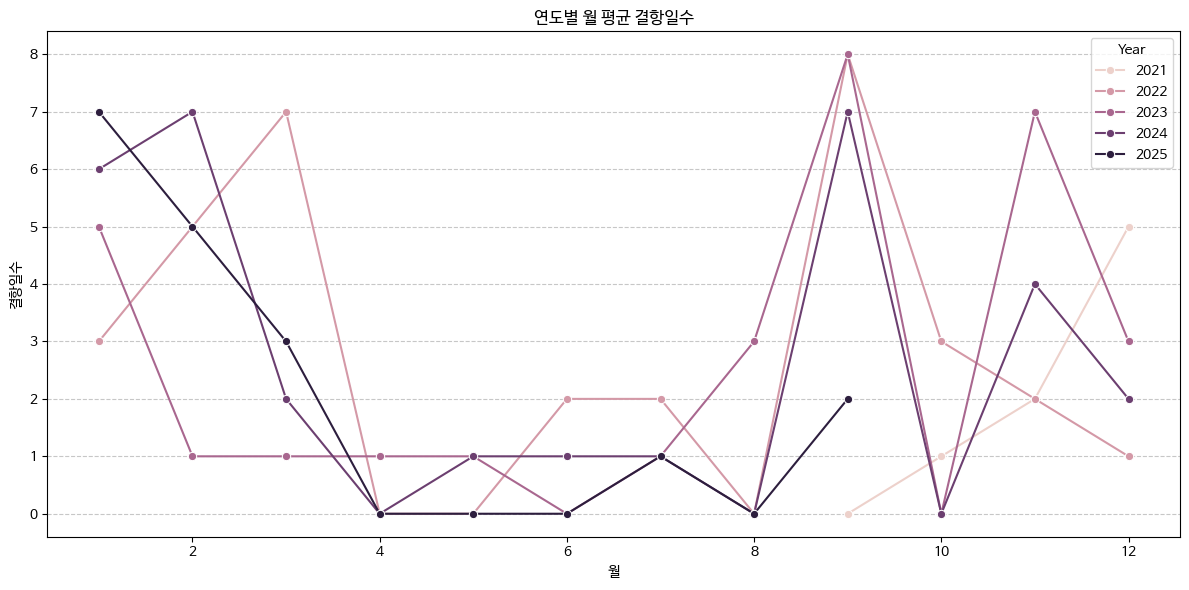

In [24]:
#연도별 결항 추이
plt.figure(figsize=(12,6))
sns.lineplot(
    data=monthly_cancel,
    x='Month',
    y='결항여부',
    hue='Year',
    marker='o'
)
plt.title('연도별 월 평균 결항일수')
plt.xlabel('월')
plt.ylabel('결항일수')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Year', loc='upper right')
plt.tight_layout()
plt.show()

In [25]:
# 공휴일

# 공휴일 리스트 정의: 문자열 → datetime (정규화)
holiday_list_str = [
    '2021-01-01','2021-02-11','2021-02-12','2021-03-01','2021-05-05','2021-05-19','2021-08-15',
    '2021-09-20','2021-09-21','2021-09-22','2021-10-04','2021-10-11',
    '2022-01-31','2022-02-01','2022-02-02','2023-03-01','2022-03-09',
    '2022-05-05','2022-06-01','2022-06-06','2022-08-15','2022-09-09','2022-09-12',
    '2022-10-03','2022-10-10',
    '2023-01-21','2023-01-23','2023-01-24','2023-03-01','2023-05-05','2023-05-29',
    '2023-06-06','2023-08-15','2023-09-28','2023-09-29','2023-10-03',
    '2023-10-09','2023-12-25',
    '2024-01-01','2024-02-09','2024-02-10','2024-02-12','2024-03-01','2024-04-10','2024-05-06',
    '2024-05-15','2024-06-06','2024-08-15','2024-09-16','2024-09-17','2024-09-18',
    '2024-10-03','2024-10-09','2024-12-25',
    '2025-01-01','2025-01-27','2025-01-28','2025-01-30','2025-03-01','2025-05-05','2025-05-06',
    '2025-06-03','2025-08-15','2025-10-03','2025-10-05','2025-10-07','2025-10-08','2025-10-09',
    '2025-12-25',
]
holiday_dates = pd.to_datetime(holiday_list_str, errors='coerce').dropna().normalize()
df_holidays = pd.DataFrame({'Date': holiday_dates}).drop_duplicates()
df_holidays['is_holiday'] = True


In [26]:
# 날짜 컬럼 정리
df_in_p['Date'] = pd.to_datetime(df_in_p['날짜'], errors='coerce').dt.normalize()
df_in_p = df_in_p.dropna(subset=['Date']).reset_index(drop=True)

In [27]:
# 숫자형 컬럼 정리

num_cols = ['합계', '대인', '중고', '경로', '소아', '편승', '유아', '임시']
#for c in num_cols:
    #if c in df_in_p.columns:
        #df_in_p[c] = df_in_p[c].astype(str).str.replace(',', '', regex=False)
        #df_in_p[c] = pd.to_numeric(df_in_p[c], errors='coerce').fillna(0)

In [28]:
# 결항 여부 계산 (모든 컬럼이 0 → 결항)
df_in_p['Operated'] = df_in_p[num_cols].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)
df_in_p['Canceled'] = 1 - df_in_p['Operated']

In [29]:
start_date = df_in_p['Date'].min()
end_date = df_in_p['Date'].max()
df_calendar = pd.DataFrame({'Date': pd.date_range(start=start_date, end=end_date, freq='D')})
df_calendar['Month'] = df_calendar['Date'].dt.month
df_calendar['Year'] = df_calendar['Date'].dt.year

# 공휴일 병합 (df_holidays 필요)
df_calendar = df_calendar.merge(df_holidays, on='Date', how='left')
df_calendar['is_holiday'] = df_calendar['is_holiday'].fillna(False)

# 요일(월=0..일=6) 컬럼 추가
df_calendar['Weekday'] = df_calendar['Date'].dt.weekday

# Day_Type 분류: 기본 Weekday, 주말 Weekend, 공휴일 Holiday/Extended
df_calendar['Day_Type'] = '주중' # '평일'을 '주중'으로 변경
df_calendar.loc[df_calendar['Weekday'] >= 5, 'Day_Type'] = '주말'
df_calendar.loc[df_calendar['is_holiday'], 'Day_Type'] = '공휴일'

/tmp/ipython-input-1342710060.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_calendar['is_holiday'] = df_calendar['is_holiday'].fillna(False)


In [30]:
# 운항일 표시 병합

daily_operated = df_in_p[['Date', 'Operated']].drop_duplicates()
df_calendar = df_calendar.merge(daily_operated, on='Date', how='left')
df_calendar['Operated'] = df_calendar['Operated'].fillna(0).astype(int)
df_calendar['Canceled'] = 1 - df_calendar['Operated']

In [31]:
df_day_type_summary = df_calendar.groupby('Day_Type').agg(
    Total_Operated_Days=('Operated', 'sum'),
    Total_Days_In_Type=('Date', 'count')
).reset_index()
df_day_type_summary['Total_Canceled_Days'] = df_day_type_summary['Total_Days_In_Type'] - df_day_type_summary['Total_Operated_Days']

# 순서 지정
order = ['주중', '주말', '공휴일']
df_day_type_summary['Day_Type'] = pd.Categorical(df_day_type_summary['Day_Type'], categories=order, ordered=True)
df_day_type_summary = df_day_type_summary.sort_values('Day_Type').reset_index(drop=True)

# Melt for bar plot
df_melt = df_day_type_summary.melt(
    id_vars='Day_Type',
    value_vars=['Total_Operated_Days', 'Total_Canceled_Days'],
    var_name='Status',
    value_name='Days_Count'
)

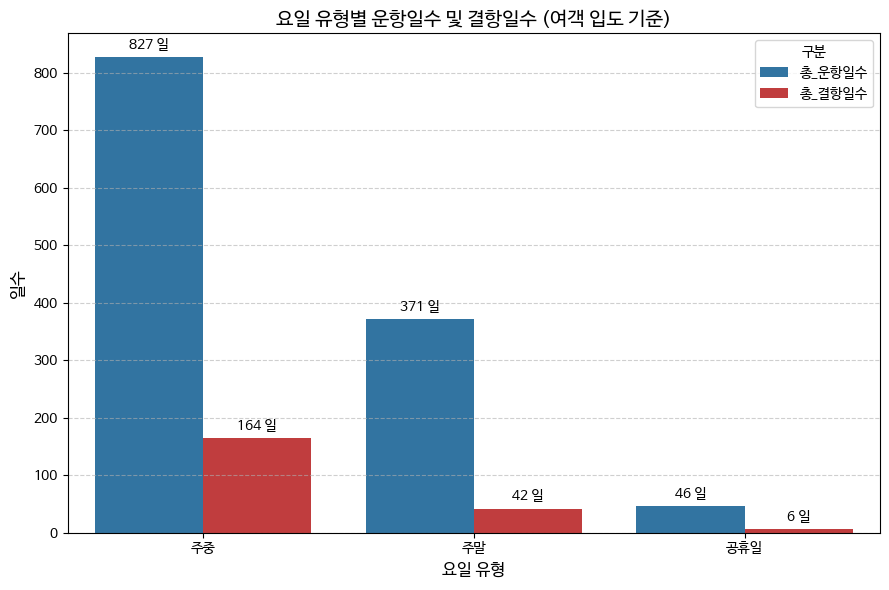

In [32]:
#시각화: 그룹형 막대그래프 (운항 vs 결항)

# 시각화용 melt
df_melt = df_day_type_summary.melt(
    id_vars='Day_Type',
    value_vars=['Total_Operated_Days', 'Total_Canceled_Days'],
    var_name='Status',
    value_name='Days_Count'
)

# Status 컬럼의 값을 한글로 변경
df_melt['Status'] = df_melt['Status'].replace({
    'Total_Operated_Days': '총_운항일수',
    'Total_Canceled_Days': '총_결항일수'
})

plt.figure(figsize=(9,6))
ax = sns.barplot(
    data=df_melt,
    x='Day_Type',
    y='Days_Count',
    hue='Status',
    palette={'총_운항일수': '#1f77b4', '총_결항일수': '#d62728'},
    order=order
)

# 바 라벨: 각 컨테이너에 대해 레이블 추가
for container in ax.containers:
    ax.bar_label(container, fmt='{:,.0f} 일', padding=3, fontsize=10)

# 제목 및 라벨
ax.set_title('요일 유형별 운항일수 및 결항일수 (여객 입도 기준)', fontsize=14)
ax.set_xlabel('요일 유형', fontsize=12)
ax.set_ylabel('일수', fontsize=12)

# Y축 정수 포맷
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.grid(axis='y', linestyle='--', alpha=0.6)
ax.legend(title='구분', loc='upper right')

plt.tight_layout()
plt.show()

In [33]:
#결과 요약 출력
summary_print = df_day_type_summary.rename(columns={
    'Day_Type': '구분',
    'Total_Operated_Days': '총 운항일수',
    'Total_Canceled_Days': '총 결항일수',
    'Total_Days_In_Type': '총 일수'
})
print("\n 주말/주중/연휴일 운항일수 분석 요약")
print(summary_print.to_markdown(index=False))


 주말/주중/연휴일 운항일수 분석 요약
| 구분   |   총 운항일수 |   총 일수 |   총 결항일수 |
|:-------|--------------:|----------:|--------------:|
| 주중   |           827 |       991 |           164 |
| 주말   |           371 |       413 |            42 |
| 공휴일 |            46 |        52 |             6 |


입도 결항일 EDA

In [64]:
# 데이터 로드
df_c_in = pd.read_csv('일별 차량 입항.csv')  # 차량 데이터
df_p_in = pd.read_csv('일별 여객 입항.csv')  # 여객 데이터

# 날짜 컬럼 처리
df_c_in['Date'] = pd.to_datetime(df_c_in['출항일'], errors='coerce').dt.normalize()
df_c_in = df_c_in.dropna(subset=['Date']).reset_index(drop=True)

df_p_in['Date'] = pd.to_datetime(df_p_in['출항일'], errors='coerce').dt.normalize() # '날짜'를 '출항일'로 수정
df_p_in = df_p_in.dropna(subset=['Date']).reset_index(drop=True)

# 1. 여객 데이터에서 모든 컬럼 0인 날 찾기
num_cols = ['대인','중고','경로','소아','편승','합계','유아','임시']
for c in num_cols:
    if c in df_p_in.columns:
        df_p_in[c] = pd.to_numeric(df_p_in[c].astype(str).str.replace(',',''), errors='coerce').fillna(0)

# 여객 기준 결항일 후보
df_p_in['All_Zero'] = (df_p_in[num_cols].sum(axis=1) == 0)

# 차량 데이터 날짜 set
vehicle_dates = set(df_c_in['Date'].unique())

# 실제 결항일: 여객 데이터에서 All_Zero이면서 차량 데이터에 없는 날짜
canceled_dates = df_p_in.loc[df_p_in['All_Zero'] & (~df_p_in['Date'].isin(vehicle_dates)), 'Date']

# 2. 차량 데이터에 결항일 표시
df_c_in['Operated'] = 1
df_c_in['Canceled'] = 0

# 결항일만 별도로 DataFrame 생성
df_canceled = pd.DataFrame({'Date': canceled_dates, 'Operated': 0, 'Canceled': 1})

# 차량 데이터와 결합
df_c_final = pd.concat([df_c_in[['Date','Operated','Canceled']], df_canceled], ignore_index=True)

# 3. 월별/성수기 정보 추가
df_c_final['Month'] = df_c_final['Date'].dt.month

monthly_avg = df_c_final.groupby('Month')['Operated'].sum().reset_index()
overall_avg = monthly_avg['Operated'].mean()
monthly_avg['Season'] = monthly_avg['Operated'].apply(lambda x: 'Peak Season' if x >= overall_avg else 'Off Peak')

df_c_final = df_c_final.merge(monthly_avg[['Month','Season']], on='Month', how='left')

# 4. 성수기/비수기별 집계
season_summary = df_c_final.groupby('Season', as_index=False).agg(
    Operated_Days=('Operated','sum'),
    Canceled_Days=('Canceled','sum')
)

print("\n=== 차량 입항: 성수기/비수기별 운항/결항 요약 ===")
print(season_summary.to_markdown(index=False))


=== 차량 입항: 성수기/비수기별 운항/결항 요약 ===
| Season      |   Operated_Days |   Canceled_Days |
|:------------|----------------:|----------------:|
| Off Peak    |             535 |             103 |
| Peak Season |             704 |              18 |


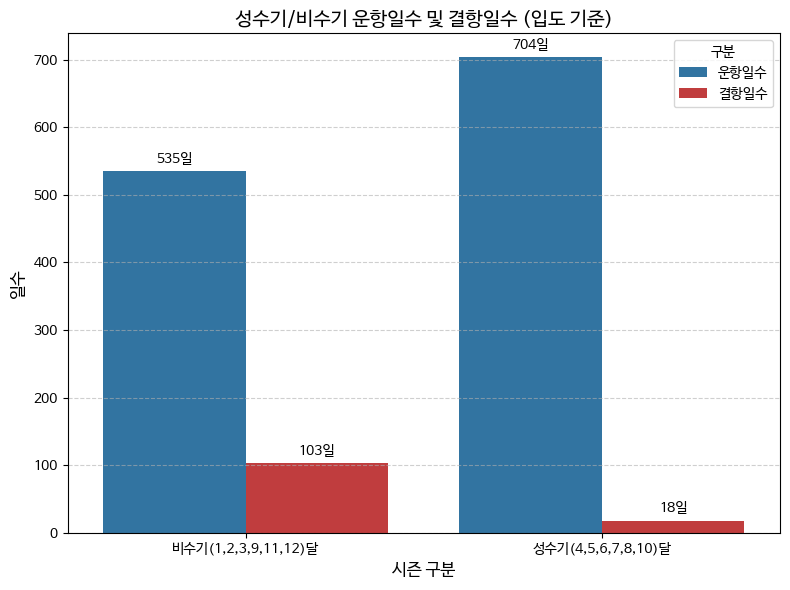

In [65]:
# 5. 시각화 (한국어 라벨)
df_melt = season_summary.melt(
    id_vars='Season',
    value_vars=['Operated_Days','Canceled_Days'],
    var_name='Status',
    value_name='Days'
)

# 한국어 변환
df_melt['Season'] = df_melt['Season'].replace({'Peak Season': '성수기(4,5,6,7,8,10)달', 'Off Peak': '비수기(1,2,3,9,11,12)달'})
df_melt['Status'] = df_melt['Status'].replace({
    'Operated_Days': '운항일수',
    'Canceled_Days': '결항일수'
})

plt.figure(figsize=(8,6))
sns.barplot(
    data=df_melt,
    x='Season',
    y='Days',
    hue='Status',
    palette={'운항일수':'#1f77b4', '결항일수':'#d62728'}
)

# 바 라벨 한국어
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='{:,.0f}일', padding=3)

plt.title('성수기/비수기 운항일수 및 결항일수 (입도 기준)', fontsize=14)
plt.xlabel('시즌 구분', fontsize=12)
plt.ylabel('일수', fontsize=12)
plt.legend(title='구분', loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


=== 성수기/비수기 운항/결항 비율(%) ===
| Season      |   Operated_Ratio |   Canceled_Ratio |
|:------------|-----------------:|-----------------:|
| Off Peak    |          83.8558 |         16.1442  |
| Peak Season |          97.5069 |          2.49307 |


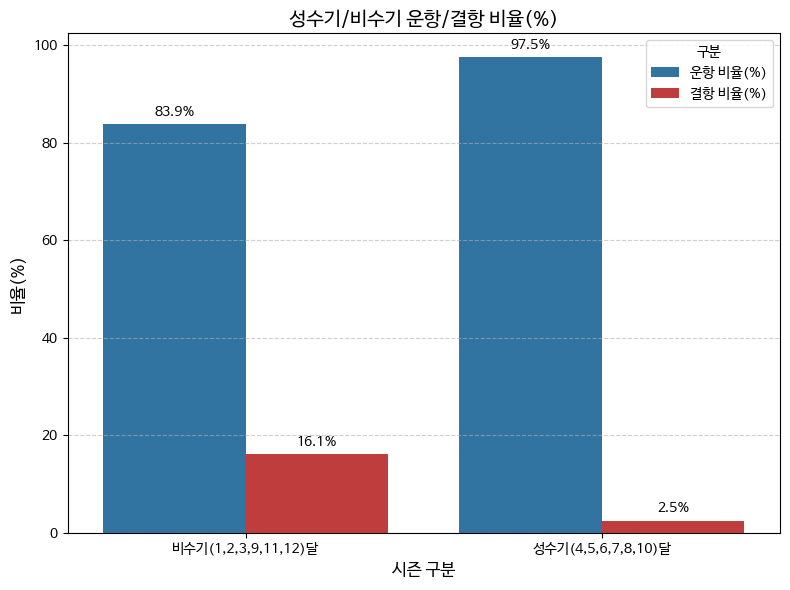

In [35]:
# 6. 성수기/비수기 비율(%) 계산
season_summary['Total_Days'] = season_summary['Operated_Days'] + season_summary['Canceled_Days']
season_summary['Operated_Ratio'] = (season_summary['Operated_Days'] / season_summary['Total_Days']) * 100
season_summary['Canceled_Ratio'] = (season_summary['Canceled_Days'] / season_summary['Total_Days']) * 100

print("\n=== 성수기/비수기 운항/결항 비율(%) ===")
print(season_summary[['Season','Operated_Ratio','Canceled_Ratio']].to_markdown(index=False))


# 7. 비율 바 그래프 (Barplot)
df_ratio_melt = season_summary.melt(
    id_vars='Season',
    value_vars=['Operated_Ratio','Canceled_Ratio'],
    var_name='Status',
    value_name='Ratio'
)

# 한국어 라벨 변환
df_ratio_melt['Season'] = df_ratio_melt['Season'].replace({
    'Peak Season': '성수기(4,5,6,7,8,10)달',
    'Off Peak': '비수기(1,2,3,9,11,12)달'
})
df_ratio_melt['Status'] = df_ratio_melt['Status'].replace({
    'Operated_Ratio': '운항 비율(%)',
    'Canceled_Ratio': '결항 비율(%)'
})

plt.figure(figsize=(8,6))
sns.barplot(
    data=df_ratio_melt,
    x='Season',
    y='Ratio',
    hue='Status',
    palette={'운항 비율(%)':'#1f77b4', '결항 비율(%)':'#d62728'}
)

# 바 라벨 표시
for c in plt.gca().containers:
    plt.gca().bar_label(c, fmt='%.1f%%', padding=3)

plt.title('성수기/비수기 운항/결항 비율(%)', fontsize=14)
plt.xlabel('시즌 구분', fontsize=12)
plt.ylabel('비율(%)', fontsize=12)
plt.legend(title='구분', loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [67]:
#결항날 실제 출력해보기

# 여객 데이터에서 모든 컬럼이 0인 날 찾기

zero_days = df_in_p[df_in_p[num_cols].sum(axis=1) == 0]['Date'].unique()

#  차량 데이터 날짜 집합
vehicle_dates = set(df_c_in['Date'].unique())

# 차량 데이터에 존재하는지 확인
zero_days_in_vehicle = [d for d in zero_days if d in vehicle_dates]
zero_days_not_in_vehicle = [d for d in zero_days if d not in vehicle_dates]

print(f"여객 데이터에서 모든 컬럼이 0인데 차량 데이터에도 있는 날짜: {zero_days_in_vehicle}")
print(f"여객 데이터에서 모든 컬럼이 0이고 차량 데이터에 없는 날짜 (결항일 후보): {zero_days_not_in_vehicle}")


여객 데이터에서 모든 컬럼이 0인데 차량 데이터에도 있는 날짜: []
여객 데이터에서 모든 컬럼이 0이고 차량 데이터에 없는 날짜 (결항일 후보): [Timestamp('2021-10-20 00:00:00'), Timestamp('2021-11-11 00:00:00'), Timestamp('2021-11-23 00:00:00'), Timestamp('2021-12-01 00:00:00'), Timestamp('2021-12-14 00:00:00'), Timestamp('2021-12-17 00:00:00'), Timestamp('2021-12-25 00:00:00'), Timestamp('2021-12-26 00:00:00'), Timestamp('2022-01-11 00:00:00'), Timestamp('2022-01-12 00:00:00'), Timestamp('2022-01-20 00:00:00'), Timestamp('2022-02-04 00:00:00'), Timestamp('2022-02-16 00:00:00'), Timestamp('2022-02-17 00:00:00'), Timestamp('2022-02-18 00:00:00'), Timestamp('2022-02-20 00:00:00'), Timestamp('2022-03-05 00:00:00'), Timestamp('2022-03-06 00:00:00'), Timestamp('2022-03-08 00:00:00'), Timestamp('2022-03-09 00:00:00'), Timestamp('2022-03-10 00:00:00'), Timestamp('2022-03-12 00:00:00'), Timestamp('2022-03-26 00:00:00'), Timestamp('2022-06-24 00:00:00'), Timestamp('2022-06-29 00:00:00'), Timestamp('2022-07-06 00:00:00'), Timestamp('2022-07-20 00:00:00')

In [68]:
# 0. 기본 데이터 준비

# 차량 운항일: 데이터에 존재하는 날짜
vehicle_operated_dates = set(df_c_in['Date'].unique())

# 결항일: 여객이 0이면서 차량 데이터에도 없는 날짜
canceled_dates = set(zero_days_not_in_vehicle)

# 전체 분석 기간 기준 달력 생성
start_date = min(df_p_in['Date'].min(), df_c_in['Date'].min())
end_date   = max(df_p_in['Date'].max(), df_c_in['Date'].max())

calendar = pd.DataFrame({'Date': pd.date_range(start=start_date, end=end_date, freq='D')})

# 1. 공휴일 / 주말 / 주중 분류

calendar = calendar.merge(df_holidays, on='Date', how='left').fillna({'is_holiday': False})

def classify_daytype(date, is_holiday):
    if is_holiday:
        return "Holiday/Extended"
    dow = date.weekday()
    if dow >= 5:
        return "Weekend"
    return "Weekday"

calendar['Day_Type'] = calendar.apply(lambda row: classify_daytype(row['Date'], row['is_holiday']), axis=1)

# 2. 운항/결항 여부 부여

calendar['Operated'] = calendar['Date'].apply(lambda d: 1 if d in vehicle_operated_dates else 0)
calendar['Canceled'] = calendar['Date'].apply(lambda d: 1 if d in canceled_dates else 0)


# 3. Day Type별 집계

summary = calendar.groupby('Day_Type').agg(
    Total_Days=('Date', 'count'),
    Operated_Days=('Operated', 'sum'),
    Canceled_Days=('Canceled', 'sum')
).reset_index()

summary['Operated_Rate (%)'] = (summary['Operated_Days'] / summary['Total_Days']) * 100
summary['Canceled_Rate (%)'] = (summary['Canceled_Days'] / summary['Total_Days']) * 100

print("### 차량 입항 기준 Day Type별 운항/결항 요약 ###")
print(summary.to_markdown(index=False, floatfmt=".1f"))

### 차량 입항 기준 Day Type별 운항/결항 요약 ###
| Day_Type         |   Total_Days |   Operated_Days |   Canceled_Days |   Operated_Rate (%) |   Canceled_Rate (%) |
|:-----------------|-------------:|----------------:|----------------:|--------------------:|--------------------:|
| Holiday/Extended |           49 |              41 |               6 |                83.7 |                12.2 |
| Weekday          |          991 |             827 |              87 |                83.5 |                 8.8 |
| Weekend          |          416 |             371 |              28 |                89.2 |                 6.7 |


/tmp/ipython-input-4250189490.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  calendar = calendar.merge(df_holidays, on='Date', how='left').fillna({'is_holiday': False})


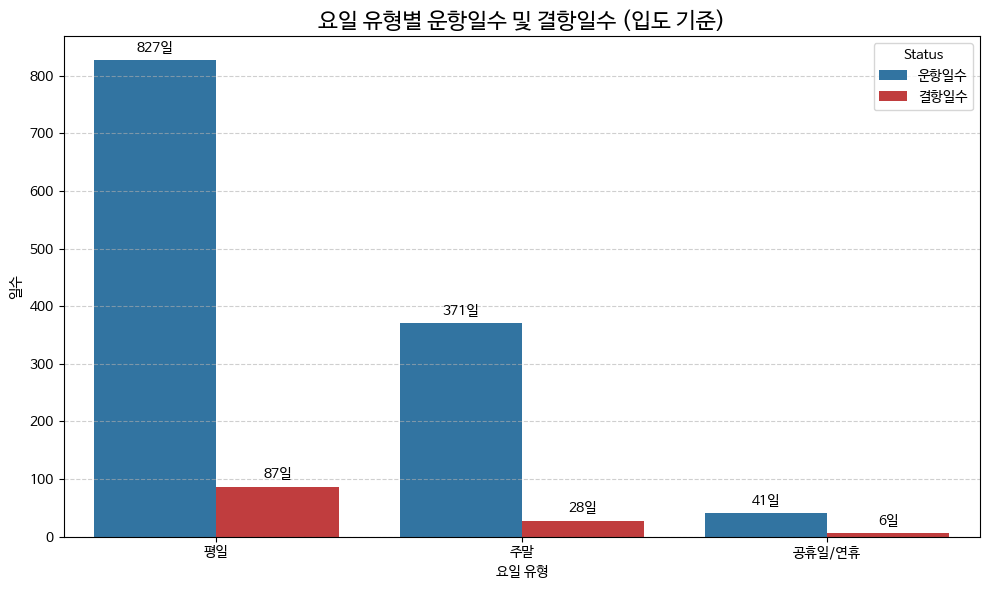

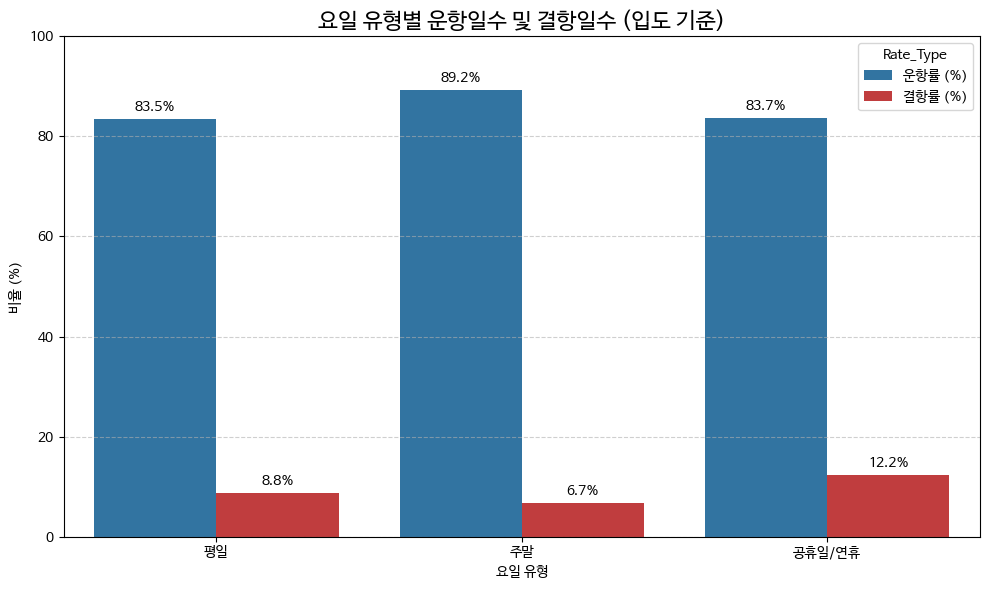

In [69]:
# 4. 시각화: 운항일수 vs 결항일수

df_melt = summary.melt(
    id_vars='Day_Type',
    value_vars=['Operated_Days','Canceled_Days'],
    var_name='Status',
    value_name='Count'
)

# 영어 → 한국어 변환 맵
day_type_map = {
    'Weekday': '평일',
    'Weekend': '주말',
    'Holiday/Extended': '공휴일/연휴'
}

status_map = {
    'Operated_Days': '운항일수',
    'Canceled_Days': '결항일수'
}

df_melt['Day_Type'] = df_melt['Day_Type'].map(day_type_map)
df_melt['Status'] = df_melt['Status'].map(status_map)

order_kr = ['평일','주말','공휴일/연휴']
df_melt['Day_Type'] = pd.Categorical(df_melt['Day_Type'], categories=order_kr, ordered=True)
df_melt.sort_values('Day_Type', inplace=True)

plt.figure(figsize=(10,6))
ax = sns.barplot(
    data=df_melt,
    x='Day_Type',
    y='Count',
    hue='Status',
    palette={'운항일수':'#1f77b4','결항일수':'#d62728'},
    order=order_kr
)

for c in ax.containers:
    ax.bar_label(c, fmt="%.0f일", padding=3)

ax.set_title('요일 유형별 운항일수 및 결항일수 (입도 기준)', fontsize=16)
ax.set_xlabel('요일 유형')
ax.set_ylabel('일수')
ax.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



# 5. 시각화: 운항률 vs 결항률

df_rate = summary.melt(
    id_vars='Day_Type',
    value_vars=['Operated_Rate (%)','Canceled_Rate (%)'],
    var_name='Rate_Type',
    value_name='Rate'
)

df_rate['Day_Type'] = df_rate['Day_Type'].map(day_type_map)

rate_map = {
    'Operated_Rate (%)': '운항률 (%)',
    'Canceled_Rate (%)': '결항률 (%)'
}

df_rate['Rate_Type'] = df_rate['Rate_Type'].map(rate_map)

df_rate['Day_Type'] = pd.Categorical(df_rate['Day_Type'], categories=order_kr, ordered=True)
df_rate.sort_values('Day_Type', inplace=True)

plt.figure(figsize=(10,6))
ax = sns.barplot(
    data=df_rate,
    x='Day_Type',
    y='Rate',
    hue='Rate_Type',
    palette={'운항률 (%)':'#1f77b4','결항률 (%)':'#d62728'},
    order=order_kr
)

for c in ax.containers:
    ax.bar_label(c, fmt="%.1f%%", padding=3)

ax.set_ylim(0, 100)
ax.set_title('요일 유형별 운항일수 및 결항일수 (입도 기준)', fontsize=16)
ax.set_xlabel('요일 유형')
ax.set_ylabel('비율 (%)')
ax.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# 성수기/비수기 운항일수 및 결항일수 (출도)

In [70]:
# 0. 날짜 및 숫자형 컬럼 전처리
df_p_out['Date'] = pd.to_datetime(df_p_out['출항일'], errors='coerce').dt.normalize()
df_p_out = df_p_out.dropna(subset=['Date']).reset_index(drop=True)

In [72]:
# 결항일을 알기 위해 차량 데이터도 로드
df_c_out = pd.read_csv('일별 차량 출항.csv')  # 차량 데이터

# 날짜 컬럼 처리
df_c_out['Date'] = pd.to_datetime(df_c_out['출항일'], errors='coerce').dt.normalize()
df_c_out = df_c_out.dropna(subset=['Date']).reset_index(drop=True)

df_p_in = df_p_out.copy() # Use a copy of df_p_out for df_p_in to ensure all original columns are available
df_p_in['Date'] = pd.to_datetime(df_p_in['출항일'], errors='coerce').dt.normalize()
df_p_in = df_p_in.dropna(subset=['Date']).reset_index(drop=True)

# 1. 여객 데이터에서 모든 컬럼 0인 날 찾기
num_cols = ['대인','중고','경로','소아','편승','합계','유아','임시']

# 여객 기준 결항일 후보
df_p_in['All_Zero'] = (df_p_in[num_cols].sum(axis=1) == 0)

# 차량 데이터 날짜 set
vehicle_dates = set(df_c_out['Date'].unique())

# 실제 결항일: 여객 데이터에서 All_Zero이면서 차량 데이터에 없는 날짜
canceled_dates = df_p_in.loc[df_p_in['All_Zero'] & (~df_p_in['Date'].isin(vehicle_dates)), 'Date']

# 2. 차량 데이터에 결항일 표시
df_c_out['Operated'] = 1
df_c_out['Canceled'] = 0

# 결항일만 별도로 DataFrame 생성
df_canceled = pd.DataFrame({'Date': canceled_dates, 'Operated': 0, 'Canceled': 1})

# 차량 데이터와 결합
df_c_final = pd.concat([df_c_out[['Date','Operated','Canceled']], df_canceled], ignore_index=True)

# 3. 월별/성수기 정보 추가
df_c_final['Month'] = df_c_final['Date'].dt.month

monthly_avg = df_c_final.groupby('Month')['Operated'].sum().reset_index()
overall_avg = monthly_avg['Operated'].mean()
monthly_avg['Season'] = monthly_avg['Operated'].apply(lambda x: '성수기(4,5,6,7,8,10)달' if x >= overall_avg else '비수기(1,2,3,9,11)달')

df_c_final = df_c_final.merge(monthly_avg[['Month','Season']], on='Month', how='left')

# 4. 성수기/비수기별 집계
season_summary = df_c_final.groupby('Season', as_index=False).agg(
    Operated_Days=('Operated','sum'),
    Canceled_Days=('Canceled','sum')
)

print("\n=== 차량 입항: 성수기/비수기별 운항/결항 요약 ===")
print(season_summary.to_markdown(index=False))


=== 차량 입항: 성수기/비수기별 운항/결항 요약 ===
| Season                 |   Operated_Days |   Canceled_Days |
|:-----------------------|----------------:|----------------:|
| 비수기(1,2,3,9,11)달   |             534 |             108 |
| 성수기(4,5,6,7,8,10)달 |             692 |              23 |


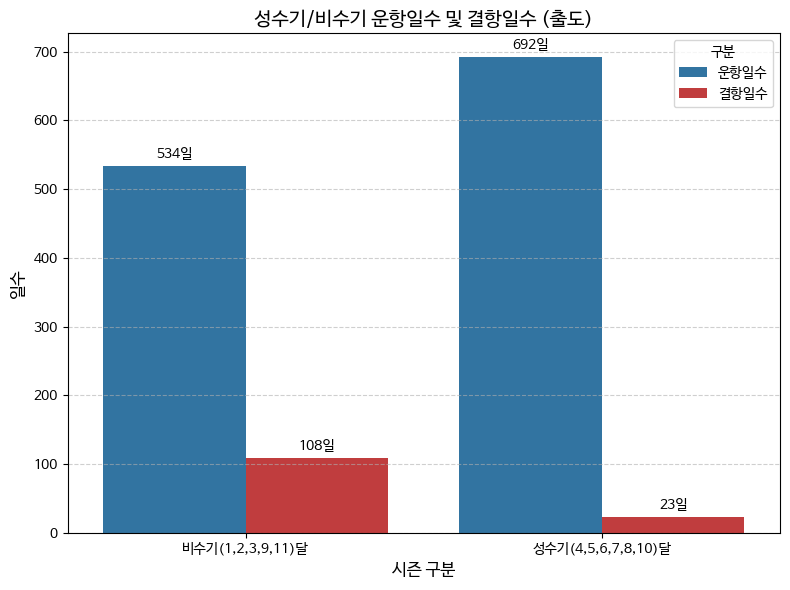

In [73]:
# 5. 시각화
df_melt = season_summary.melt(
    id_vars='Season',
    value_vars=['Operated_Days','Canceled_Days'],
    var_name='Status',
    value_name='Days'
)
df_melt['Status'] = df_melt['Status'].replace({
    'Operated_Days':'운항일수',
    'Canceled_Days':'결항일수'
})

plt.figure(figsize=(8,6))
sns.barplot(
    data=df_melt,
    x='Season',
    y='Days',
    hue='Status',
    palette={'운항일수':'#1f77b4', '결항일수':'#d62728'}
)

for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='{:,.0f}일', padding=3)

plt.title('성수기/비수기 운항일수 및 결항일수 (출도)', fontsize=14)
plt.xlabel('시즌 구분', fontsize=12)
plt.ylabel('일수', fontsize=12)
plt.legend(title='구분', loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [74]:
# 7. 비중/비율 계산

# 총 일수 계산
season_summary['Total_Days'] = season_summary['Operated_Days'] + season_summary['Canceled_Days']

# 비율 계산
season_summary['Operated_Rate (%)'] = (season_summary['Operated_Days'] / season_summary['Total_Days']) * 100
season_summary['Canceled_Rate (%)'] = (season_summary['Canceled_Days'] / season_summary['Total_Days']) * 100

# 결과 확인
print("\n### 시즌에 따른 운행 정보 ###")
print(season_summary[['Season', 'Total_Days', 'Operated_Days', 'Operated_Rate (%)', 'Canceled_Rate (%)']]
      .to_markdown(index=False, floatfmt=".1f"))


### 시즌에 따른 운행 정보 ###
| Season                 |   Total_Days |   Operated_Days |   Operated_Rate (%) |   Canceled_Rate (%) |
|:-----------------------|-------------:|----------------:|--------------------:|--------------------:|
| 비수기(1,2,3,9,11)달   |          642 |             534 |                83.2 |                16.8 |
| 성수기(4,5,6,7,8,10)달 |          715 |             692 |                96.8 |                 3.2 |


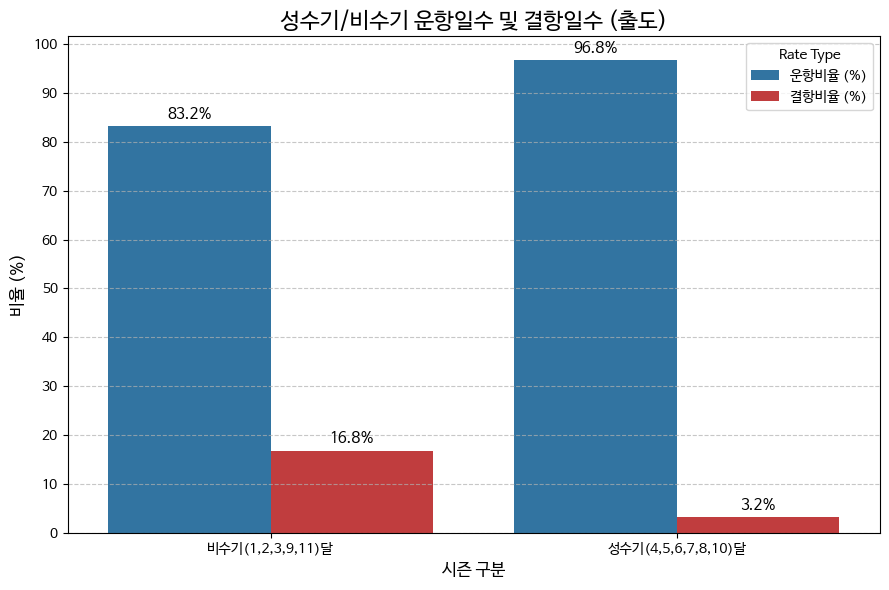

In [75]:
# 8. 비중 시각화

# Melt 데이터프레임 생성
df_rate_melt = season_summary.melt(
    id_vars='Season',
    value_vars=['Operated_Rate (%)', 'Canceled_Rate (%)'], # Corrected column names
    var_name='Rate_Type',
    value_name='Rate'
)

# 한국어로 바꿈
df_rate_melt['Rate_Type'] = df_rate_melt['Rate_Type'].replace({
    'Operated_Rate (%)': '운항비율 (%)',
    'Canceled_Rate (%)': '결항비율 (%)'
})

plt.figure(figsize=(9, 6))
ax = sns.barplot(
    data=df_rate_melt,
    x='Season',
    y='Rate',
    hue='Rate_Type',
    palette={'운항비율 (%)': '#1f77b4', '결항비율 (%)': '#d62728'}
)

# 바 라벨 표시
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', fontsize=11, padding=3)

# 제목 및 축 라벨
ax.set_title('성수기/비수기 운항일수 및 결항일수 (출도)', fontsize=16)
ax.set_xlabel('시즌 구분', fontsize=12)
ax.set_ylabel('비율 (%)', fontsize=12)
ax.set_yticks(np.arange(0, 101, 10))  # 0~100% 단위
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.legend(title='Rate Type', loc='upper right')

plt.tight_layout()
plt.show()

# **결항일/운행일 계산**

In [76]:
#데이터 로드
df_p_out_days = pd.read_csv('일별 여객 출항.csv')

# Rename date column consistently
if '출항일' in df_p_out_days.columns:
    df_p_out_days.rename(columns={'출항일': '날짜'}, inplace=True)

# Convert '날짜' to datetime and drop rows with invalid dates
df_p_out_days['날짜'] = pd.to_datetime(df_p_out_days['날짜'], errors='coerce').dt.normalize()
df_p_out_days = df_p_out_days.dropna(subset=['날짜']).reset_index(drop=True)

# Extract year and month
df_p_out_days['연도'] = df_p_out_days['날짜'].dt.year
df_p_out_days['월'] = df_p_out_days['날짜'].dt.month

# 숫자형 컬럼 리스트 정의
num_cols = ['대인', '중고', '경로', '소아', '편승', '합계', '유아', '임시']

# 숫자형 컬럼 정리 (clean_numeric_columns 함수를 직접 사용)
df_p_out_days = clean_numeric_columns(df_p_out_days, num_cols)

In [77]:
# 1. 운항 여부 및 결항일 계산 (모든 컬럼 0 → 결항)

df_p_out_days = clean_numeric_columns(df_p_out_days, num_cols)

df_p_out_days['운항여부'] = (df_p_out_days[num_cols].sum(axis=1) > 0).astype(int)
df_p_out_days['결항일수'] = 1 - df_p_out_days['운항여부']

# 연도/월 컬럼 생성
df_p_out_days['Year'] = df_p_out_days['날짜'].dt.year
df_p_out_days['Month'] = df_p_out_days['날짜'].dt.month

In [78]:
# 월별 분석 데이터
monthly_analysis = df_p_out_days.groupby(['Year', 'Month']).agg(
    달력일수=('날짜', 'count'),
    결항일수=('결항일수', 'sum')
).reset_index()

/tmp/ipython-input-618000747.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=monthly_avg_no_sail, x='Month', y='총_결항일수', palette='Reds')


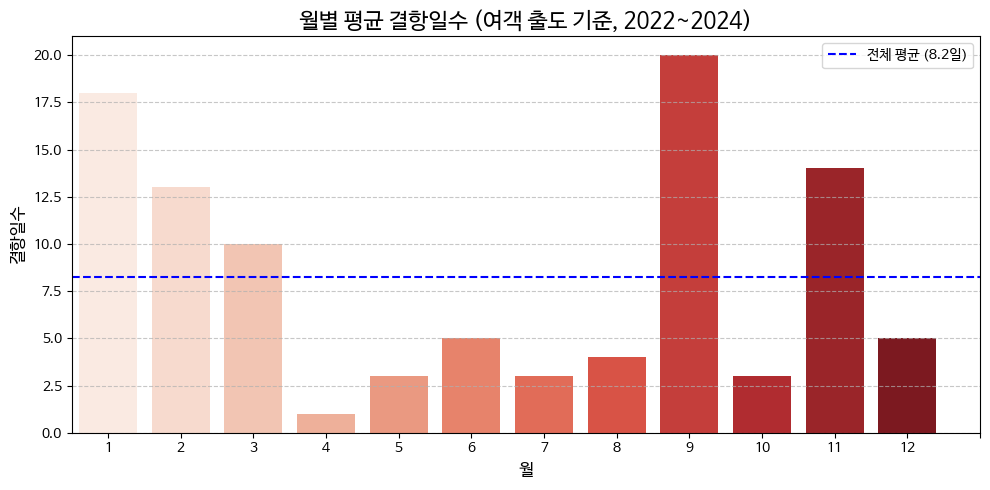

In [79]:
# 다 있는 연도 기준 평균 결항일 (2022~2024)
All_years = [2022, 2023, 2024]
df_complete = monthly_analysis[monthly_analysis['Year'].isin(All_years)]

monthly_avg_no_sail = df_complete.groupby('Month')['결항일수'].sum().reset_index()
monthly_avg_no_sail.rename(columns={'결항일수': '총_결항일수'}, inplace=True)
overall_avg = monthly_avg_no_sail['총_결항일수'].mean()

# Bar Plot: 월별 평균 결항일
plt.figure(figsize=(10,5))
ax = sns.barplot(data=monthly_avg_no_sail, x='Month', y='총_결항일수', palette='Reds')

ax.axhline(overall_avg, color='blue', linestyle='--', linewidth=1.5,
           label=f'전체 평균 ({overall_avg:.1f}일)')

# 한국어 제목/라벨
ax.set_title('월별 평균 결항일수 (여객 출도 기준, 2022~2024)', fontsize=16)
ax.set_xlabel('월', fontsize=12)
ax.set_ylabel('결항일수', fontsize=12)

ax.set_xticks(range(0, 13))
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=False))
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()


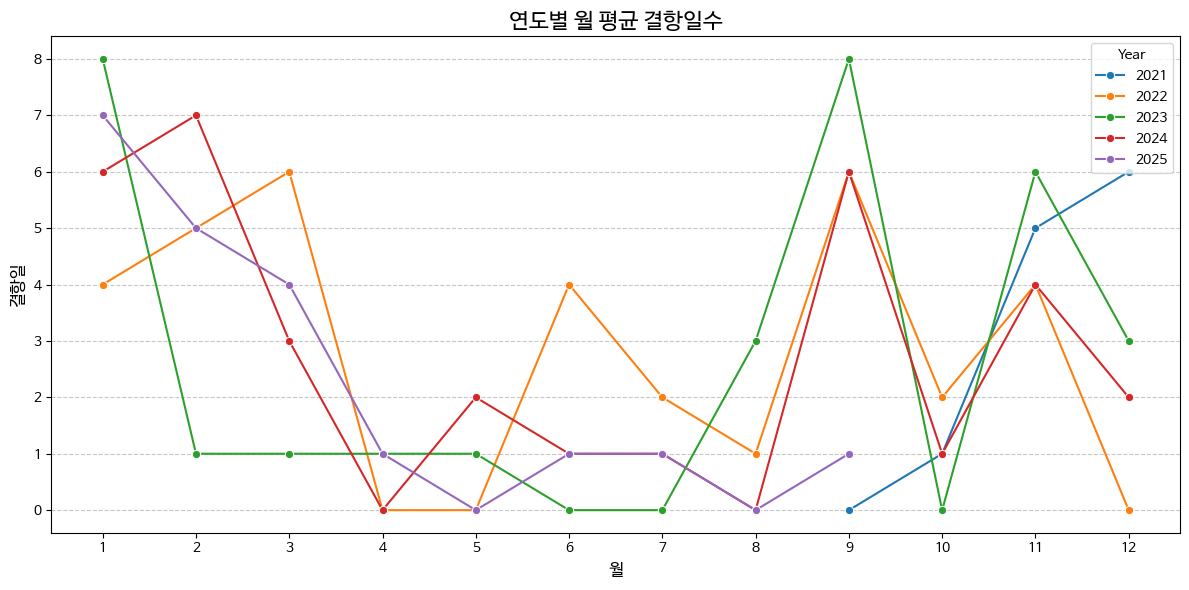

In [80]:
# 연도별 결항일 추이 Line Plot
plt.figure(figsize=(12,6))
ax = sns.lineplot(
    data=monthly_analysis,
    x='Month',
    y='결항일수',
    hue='Year',
    marker='o',
    palette=sns.color_palette("tab10", n_colors=len(monthly_analysis['Year'].unique()))
)
ax.set_title('연도별 월 평균 결항일수', fontsize=16)
ax.set_xlabel('월', fontsize=12)
ax.set_ylabel('결항일', fontsize=12)
ax.set_xticks(range(1, 13))
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.legend(title='Year', loc='upper right')
plt.tight_layout()
plt.show()

In [52]:
# 전체 달력 + 공휴일/요일 분류
holiday_list = [
    '2021-01-01','2021-02-11','2021-02-12','2021-03-01','2021-05-05','2021-05-19','2021-08-16',
    '2021-09-20','2021-09-21','2021-09-22','2021-10-04','2021-10-11',
    '2022-01-31','2022-02-01','2022-02-02','2022-03-09','2022-05-05','2022-06-01','2022-06-06',
    '2022-08-15','2022-09-09','2022-09-12','2022-10-03','2022-10-10',
    '2023-01-23','2023-01-24','2023-03-01','2023-05-05','2023-06-06','2023-08-15',
    '2023-09-28','2023-09-29','2023-10-03','2023-10-09','2023-12-25',
    '2024-01-01','2024-02-09','2024-02-12','2024-03-01','2024-04-10','2024-05-06',
    '2024-05-15','2024-06-06','2024-08-15','2024-09-16','2024-09-17','2024-09-18',
    '2024-10-03','2024-10-09','2024-12-25',
    '2025-01-01','2025-01-28','2025-01-29','2025-01-30','2025-03-03','2025-05-05','2025-05-06',
    '2025-06-06','2025-08-15','2025-10-03','2025-10-07','2025-10-08','2025-10-09','2025-12-25'
]

holiday_dates = pd.to_datetime(holiday_list, errors='coerce').dropna().normalize()
df_holidays = pd.DataFrame({'Date': holiday_dates}).drop_duplicates()
df_holidays['is_holiday'] = True

# 전체 달력 생성
full_range = pd.date_range(df_p_out_days['날짜'].min(), df_p_out_days['날짜'].max(), freq='D')
df_calendar = pd.DataFrame({'Date': full_range})
df_calendar['Month'] = df_calendar['Date'].dt.month
df_calendar['weekday'] = df_calendar['Date'].dt.weekday

df_calendar = df_calendar.merge(df_holidays, on='Date', how='left').fillna({'is_holiday': False})
df_calendar['is_holiday'] = df_calendar['is_holiday'].astype(bool)

# Day Type 분류
def classify_day(row):
    if row['is_holiday']:
        return '공휴일/연휴'
    elif row['weekday'] >= 5:
        return '주말'
    else:
        return '주중'

df_calendar['요일구분'] = df_calendar.apply(classify_day, axis=1)

# 운항일/결항일 계산
daily_operated = df_p_out_days[['날짜', '운항여부']].drop_duplicates().rename(columns={'날짜':'Date'})
df_calendar = df_calendar.merge(daily_operated, on='Date', how='left').fillna({'운항여부':0})

df_calendar['결항여부'] = 1 - df_calendar['운항여부']

# 4. 요약
df_day_type_summary = df_calendar.groupby('요일구분').agg(
    총_운항일수=('운항여부', 'sum'),
    총_결항일수=('결항여부', 'sum'),
    총_일수=('Date', 'count')
).reset_index()

# Melt for plotting
df_melt = df_day_type_summary.melt(
    id_vars='요일구분',
    value_vars=['총_운항일수', '총_결항일수'],
    var_name='상태',
    value_name='일수'
)
# 요일구분 순서 지정
order = ['주중', '주말', '공휴일/연휴']
df_day_type_summary['요일구분'] = pd.Categorical(df_day_type_summary['요일구분'], categories=order, ordered=True)
df_day_type_summary = df_day_type_summary.sort_values('요일구분')

# melt 데이터도 동일하게 적용
df_melt['요일구분'] = pd.Categorical(df_melt['요일구분'], categories=order, ordered=True)
df_melt = df_melt.sort_values('요일구분')


/tmp/ipython-input-233376437.py:26: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_calendar = df_calendar.merge(df_holidays, on='Date', how='left').fillna({'is_holiday': False})


# 해양 데이터 EDA

In [53]:
# 해양 데이터 로드

file_list = glob.glob('울릉도_해양날씨_*.csv')

dfs = []
for f in file_list:
    df = pd.read_csv(f, encoding='cp949')
    df.columns = df.columns.str.strip()

    df['일시'] = pd.to_datetime(df['일시']).dt.normalize()

    # rename 없이 원본 컬럼 그대로 사용
    df = df[['일시', '평균 유의 파고(m)', '평균 최대 파고(m)']].dropna()
    dfs.append(df)

df_wave = pd.concat(dfs, ignore_index=True)

# 병합을 위해 컬럼명 맞추기
df_wave = df_wave.rename(columns={'일시': '날짜'})

# 0. 달력 + 결항일
start_date = df_p_in['Date'].min()
end_date = df_p_in['Date'].max()

df_calendar = pd.DataFrame({'날짜': pd.date_range(start=start_date, end=end_date, freq='D')})

vehicle_operated_dates = set(df_c_in['Date'].unique())
canceled_dates = set(zero_days_not_in_vehicle)

df_calendar['운항여부'] = df_calendar['날짜'].apply(lambda d: 1 if d in vehicle_operated_dates else 0)
df_calendar['결항여부'] = df_calendar['날짜'].apply(lambda d: 1 if d in canceled_dates else 0)

# 운항=1 && 결항=1 → 결항=0 으로 정리
df_calendar.loc[(df_calendar['운항여부']==1) & (df_calendar['결항여부']==1), '결항여부'] = 0

# 1. 육상 날씨 데이터
df_weather = pd.read_csv('울릉도_날씨.csv', encoding='cp949')
df_weather.rename(columns={
    '일시':'날짜',
    '최대 풍속(m/s)':'최대풍속',
    '평균기온(°C)':'평균기온',
    '평균 이슬점온도(°C)':'평균이슬점온도'
}, inplace=True)

df_weather['날짜'] = pd.to_datetime(df_weather['날짜']).dt.normalize()
df_weather['T_minus_Td'] = df_weather['평균기온'] - df_weather['평균이슬점온도']
df_weather = df_weather[['날짜','최대풍속','평균기온','평균이슬점온도','T_minus_Td']].dropna()

# 2. 해양 날씨 데이터 (이미 연도별 통합된 df_wave_all 사용)
# df_wave_all = (연도별 처리해 만든 데이터프레임)

# 혹시 날짜 타입이 object이면 변환
df_wave['날짜'] = pd.to_datetime(df_wave['날짜']).dt.normalize()

# 3. 세 데이터 병합
df_combined = (
    df_calendar
    .merge(df_weather, on='날짜', how='inner')
    .merge(df_wave, on='날짜', how='inner')
)

df_combined['상태'] = df_combined['결항여부'].replace({1:'결항', 0:'운항'})

/tmp/ipython-input-426733161.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


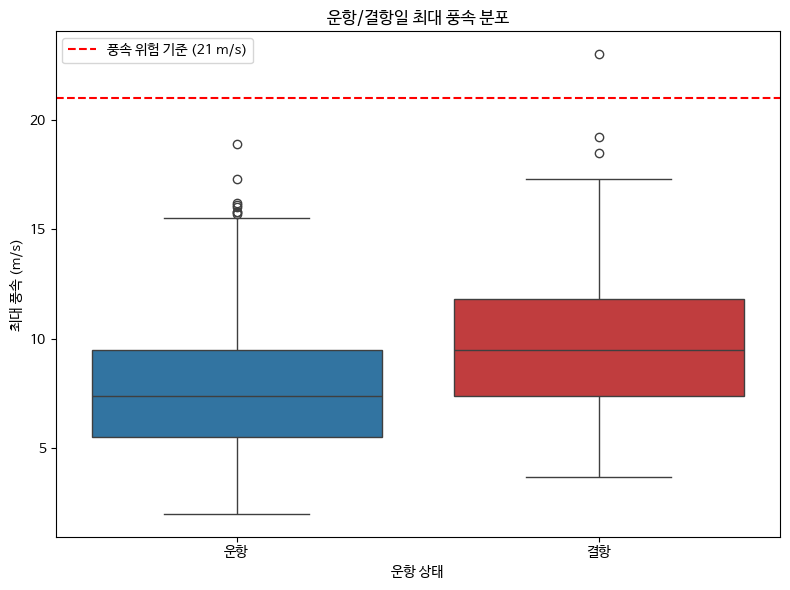

In [54]:
# 4. EDA 시각화

# A. 최대 풍속
plt.figure(figsize=(8,6))
sns.boxplot(
    x='상태', y='최대풍속', data=df_combined,
    palette={'운항':'#1f77b4','결항':'#d62728'},
    order=['운항','결항']
)
plt.axhline(21, color='red', linestyle='--', label='풍속 위험 기준 (21 m/s)')
plt.title('운항/결항일 최대 풍속 분포')
plt.xlabel('운항 상태')
plt.ylabel('최대 풍속 (m/s)')
plt.legend()
plt.tight_layout()
plt.show()

/tmp/ipython-input-2794739049.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


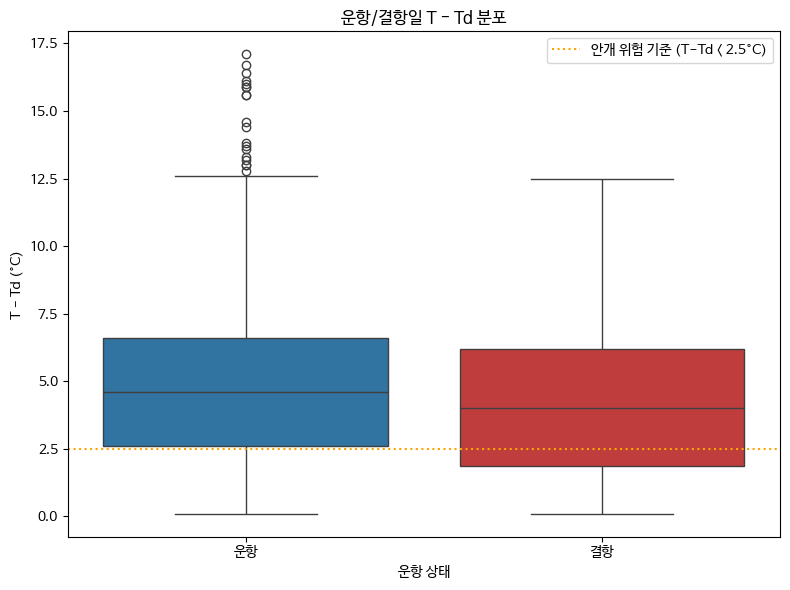

In [55]:
#T - Td (안개지표)
plt.figure(figsize=(8,6))
sns.boxplot(
    x='상태', y='T_minus_Td', data=df_combined,
    palette={'운항':'#1f77b4','결항':'#d62728'},
    order=['운항','결항']
)
plt.axhline(2.5, color='orange', linestyle=':', label='안개 위험 기준 (T-Td < 2.5°C)')
plt.title('운항/결항일 T - Td 분포')
plt.xlabel('운항 상태')
plt.ylabel('T - Td (°C)')
plt.legend()
plt.tight_layout()
plt.show()

/tmp/ipython-input-672302960.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


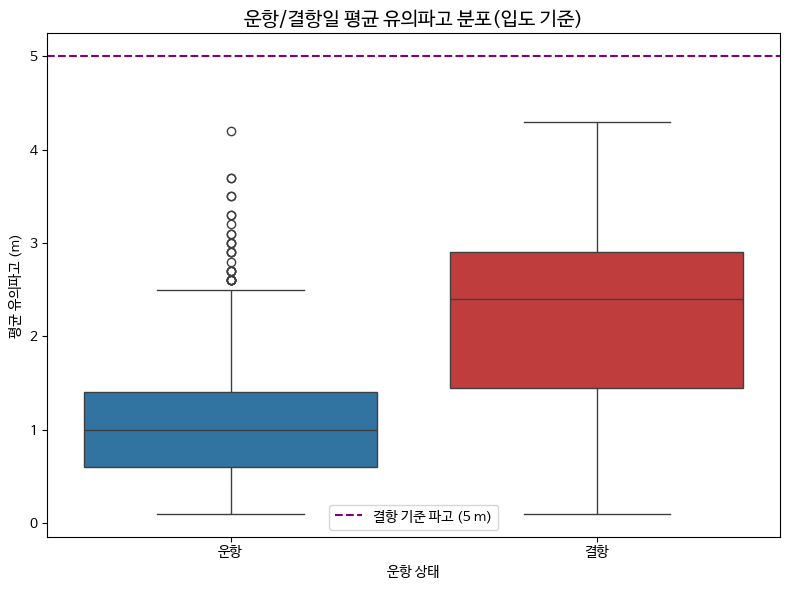

In [56]:
#유의파고
plt.figure(figsize=(8,6))
sns.boxplot(
    x='상태',
    y='평균 유의 파고(m)',
    data=df_combined,
    palette={'운항':'#1f77b4', '결항':'#d62728'},
    order=['운항','결항']
)
plt.axhline(5, color='purple', linestyle='--', label='결항 기준 파고 (5 m)')
plt.title('운항/결항일 평균 유의파고 분포(입도 기준)', fontsize=14)
plt.xlabel('운항 상태')
plt.ylabel('평균 유의파고 (m)')
plt.legend()
plt.tight_layout()
plt.show()

/tmp/ipython-input-2083356164.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


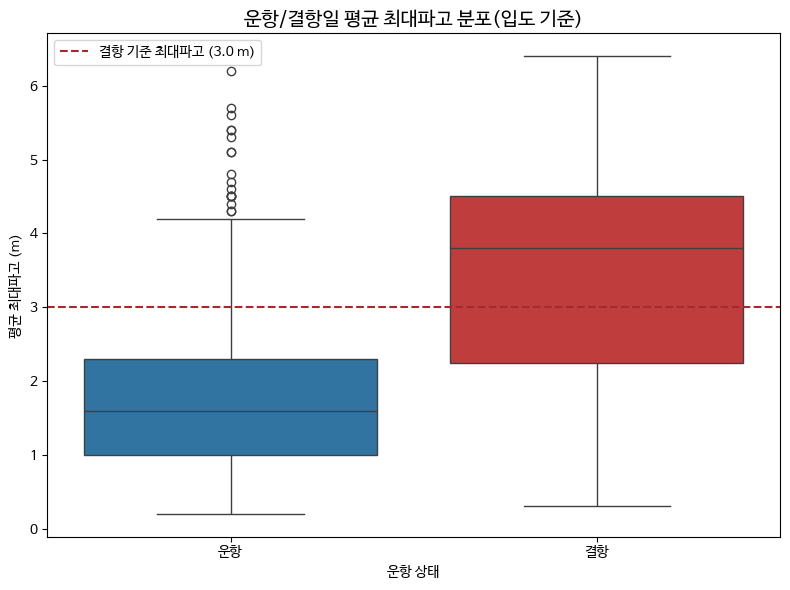

In [57]:
# 최대파고
plt.figure(figsize=(8,6))
sns.boxplot(
    x='상태',
    y='평균 최대 파고(m)',   # 이 컬럼명 그대로
    data=df_combined,
    palette={'운항':'#1f77b4', '결항':'#d62728'},
    order=['운항','결항']
)
plt.axhline(3.0, color='brown', linestyle='--', label='결항 기준 최대파고 (3.0 m)')
plt.title('운항/결항일 평균 최대파고 분포(입도 기준)', fontsize=14)
plt.xlabel('운항 상태')
plt.ylabel('평균 최대파고 (m)')
plt.legend()
plt.tight_layout()
plt.show()

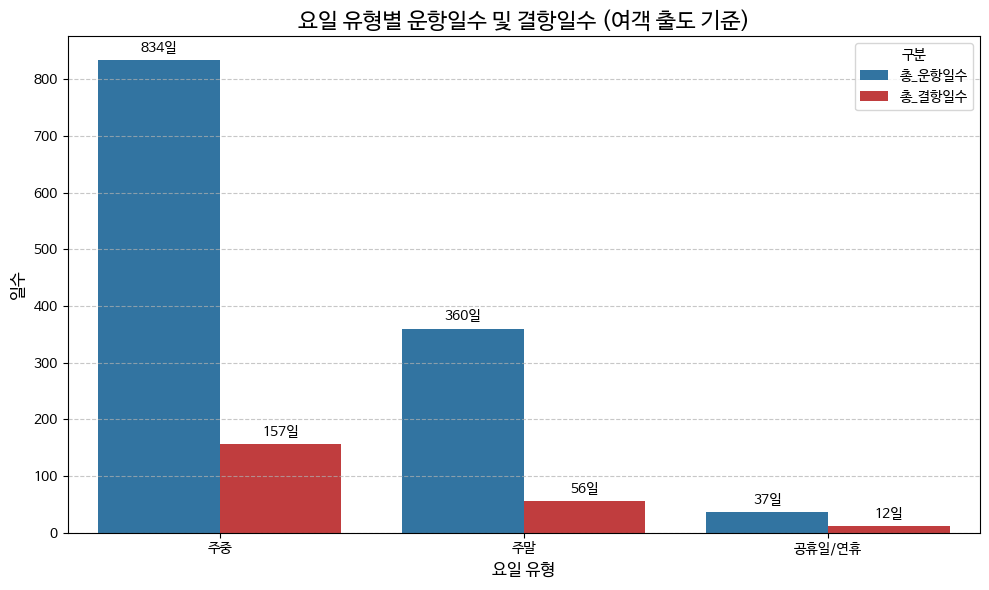


요일별 운항/결항 요약
| 요일구분    |   총_운항일수 |   총_결항일수 |   총_일수 |
|:------------|--------------:|--------------:|----------:|
| 주중        |           834 |           157 |       991 |
| 주말        |           360 |            56 |       416 |
| 공휴일/연휴 |            37 |            12 |        49 |


In [58]:
#시각화
plt.figure(figsize=(10,6))
sns.barplot(
    data=df_melt,
    x='요일구분',
    y='일수',
    hue='상태',
    palette={'총_운항일수':'#1f77b4','총_결항일수':'#d62728'}
)

# 바 레이블 한국어
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='{:,.0f}일', fontsize=10, padding=3)

plt.title('요일 유형별 운항일수 및 결항일수 (여객 출도 기준)', fontsize=16)
plt.xlabel('요일 유형', fontsize=12)
plt.ylabel('일수', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='구분', loc='upper right')
plt.tight_layout()
plt.show()

# 결과 요약
print("\n요일별 운항/결항 요약")
print(df_day_type_summary.to_markdown(index=False))

In [59]:
# 퍼센트 계산
df_day_type_summary['운항률 (%)'] = (df_day_type_summary['총_운항일수'] / df_day_type_summary['총_일수']) * 100
df_day_type_summary['결항률 (%)'] = (df_day_type_summary['총_결항일수'] / df_day_type_summary['총_일수']) * 100

# 소수점 1자리로 표시
df_day_type_summary['운항률 (%)'] = df_day_type_summary['운항률 (%)'].round(1)
df_day_type_summary['결항률 (%)'] = df_day_type_summary['결항률 (%)'].round(1)

# 결과 출력
print("\n요일별 운항/결항 요약 (퍼센트 포함)")
print(df_day_type_summary.to_markdown(index=False))



요일별 운항/결항 요약 (퍼센트 포함)
| 요일구분    |   총_운항일수 |   총_결항일수 |   총_일수 |   운항률 (%) |   결항률 (%) |
|:------------|--------------:|--------------:|----------:|-------------:|-------------:|
| 주중        |           834 |           157 |       991 |         84.2 |         15.8 |
| 주말        |           360 |            56 |       416 |         86.5 |         13.5 |
| 공휴일/연휴 |            37 |            12 |        49 |         75.5 |         24.5 |


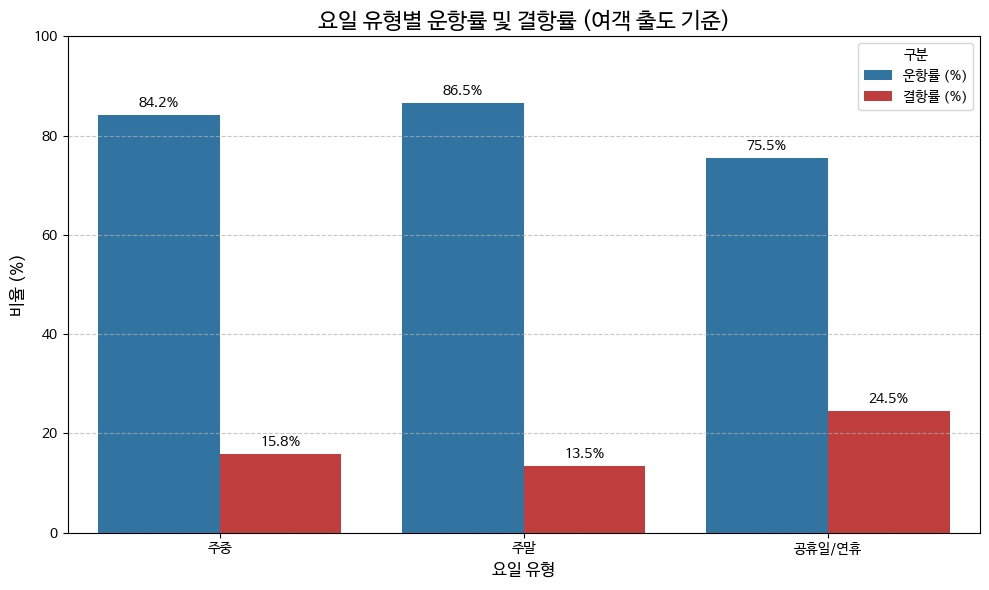

In [60]:
# 요일별 운항률 vs 결항률
plt.figure(figsize=(10,6))

# melt로 long-form 변환
df_pct_melt = df_day_type_summary.melt(
    id_vars='요일구분',
    value_vars=['운항률 (%)', '결항률 (%)'],
    var_name='상태',
    value_name='비율'
)

# 막대 순서 지정
order = ['주중', '주말', '공휴일/연휴']
df_pct_melt['요일구분'] = pd.Categorical(df_pct_melt['요일구분'], categories=order, ordered=True)
df_pct_melt = df_pct_melt.sort_values('요일구분')

# 색상 지정
palette = {'운항률 (%)':'#1f77b4', '결항률 (%)':'#d62728'}

# 시각화
ax = sns.barplot(
    data=df_pct_melt,
    x='요일구분',
    y='비율',
    hue='상태',
    palette=palette
)

# 막대 위 퍼센트 라벨
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', padding=3)

# 그래프 옵션
ax.set_ylim(0, 100)
ax.set_title('요일 유형별 운항률 및 결항률 (여객 출도 기준)', fontsize=16)
ax.set_xlabel('요일 유형', fontsize=12)
ax.set_ylabel('비율 (%)', fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.legend(title='구분', loc='upper right')
plt.tight_layout()
plt.show()


/tmp/ipython-input-1937491355.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


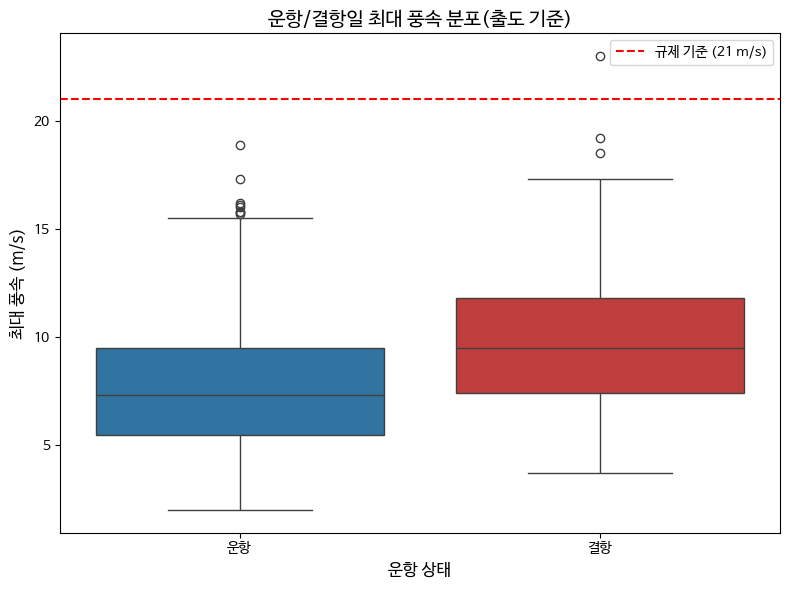

/tmp/ipython-input-1937491355.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


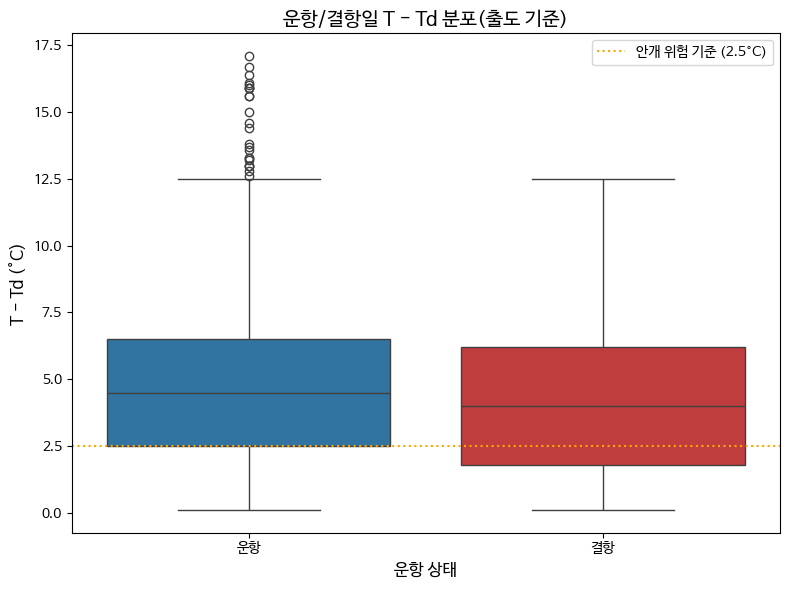

In [61]:
# 결항일 활용
start_date = df_p_in['Date'].min()
end_date = df_p_in['Date'].max()
df_calendar = pd.DataFrame({'날짜': pd.date_range(start=start_date, end=end_date, freq='D')})

vehicle_operated_dates = set(df_c_out['Date'].unique())
# Use the already defined 'canceled_dates' from previous processing
canceled_dates_set = set(canceled_dates)

df_calendar['운항여부'] = df_calendar['날짜'].apply(lambda d: 1 if d in vehicle_operated_dates else 0)
df_calendar['결항여부'] = df_calendar['날짜'].apply(lambda d: 1 if d in canceled_dates_set else 0)

#  날씨 데이터 로드 및 병합
df_weather = pd.read_csv('울릉도_날씨.csv', encoding='cp949')
df_weather.rename(columns={'일시':'날짜',
                           '최대 풍속(m/s)':'최대풍속',
                           '평균기온(°C)':'평균기온',
                           '평균 이슬점온도(°C)':'평균이슬점온도'}, inplace=True)
df_weather['날짜'] = pd.to_datetime(df_weather['날짜']).dt.normalize()
df_weather = df_weather[['날짜','최대풍속','평균기온','평균이슬점온도']].dropna()

df_combined = pd.merge(df_calendar, df_weather, on='날짜', how='inner')
df_combined['T_minus_Td'] = df_combined['평균기온'] - df_combined['평균이슬점온도']
df_combined['상태'] = df_combined['결항여부'].replace({1:'결항', 0:'운항'})

# EDA 시각화
# 최대 풍속
plt.figure(figsize=(8,6))
sns.boxplot(
    x='상태',
    y='최대풍속',
    data=df_combined,
    palette={'운항':'#1f77b4', '결항':'#d62728'},
    order=['운항','결항']
)
plt.axhline(21, color='red', linestyle='--', label='규제 기준 (21 m/s)')
plt.title('운항/결항일 최대 풍속 분포(출도 기준)', fontsize=14)
plt.xlabel('운항 상태', fontsize=12)
plt.ylabel('최대 풍속 (m/s)', fontsize=12)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# T - Td 차이
plt.figure(figsize=(8,6))
sns.boxplot(
    x='상태',
    y='T_minus_Td',
    data=df_combined,
    palette={'운항':'#1f77b4', '결항':'#d62728'},
    order=['운항','결항']
)
plt.axhline(2.5, color='orange', linestyle=':', label='안개 위험 기준 (2.5°C)')
plt.title('운항/결항일 T - Td 분포(출도 기준)', fontsize=14)
plt.xlabel('운항 상태', fontsize=12)
plt.ylabel('T - Td (°C)', fontsize=12)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [62]:

# 달력 + 결항일
start_date = df_p_in['Date'].min()
end_date = df_p_in['Date'].max()

df_calendar = pd.DataFrame({'날짜': pd.date_range(start=start_date, end=end_date, freq='D')})

vehicle_operated_dates = set(df_c_out['Date'].unique())
canceled_dates = set(canceled_dates_set)

df_calendar['운항여부'] = df_calendar['날짜'].apply(lambda d: 1 if d in vehicle_operated_dates else 0)
df_calendar['결항여부'] = df_calendar['날짜'].apply(lambda d: 1 if d in canceled_dates else 0)

# 운항=1 & 결항=1 → 결항=0 으로 정리
df_calendar.loc[(df_calendar['운항여부']==1) & (df_calendar['결항여부']==1), '결항여부'] = 0


# 육상 날씨 데이터
df_weather = pd.read_csv('울릉도_날씨.csv', encoding='cp949')
df_weather.rename(columns={
    '일시':'날짜',
    '최대 풍속(m/s)':'최대풍속',
    '평균기온(°C)':'평균기온',
    '평균 이슬점온도(°C)':'평균이슬점온도'
}, inplace=True)

df_weather['날짜'] = pd.to_datetime(df_weather['날짜']).dt.normalize()
df_weather['T_minus_Td'] = df_weather['평균기온'] - df_weather['평균이슬점온도']
df_weather = df_weather[['날짜','최대풍속','평균기온','평균이슬점온도','T_minus_Td']].dropna()

# 해양 날씨 데이터 (이미 연도별 통합된 df_wave_all 사용)

# 혹시 날짜 타입이 object이면 변환
df_wave['날짜'] = pd.to_datetime(df_wave['날짜']).dt.normalize()

# 세 데이터 병합
df_combined = (
    df_calendar
    .merge(df_weather, on='날짜', how='inner')
    .merge(df_wave, on='날짜', how='inner')
)

df_combined['상태'] = df_combined['결항여부'].replace({1:'결항', 0:'운항'})

/tmp/ipython-input-2822105008.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


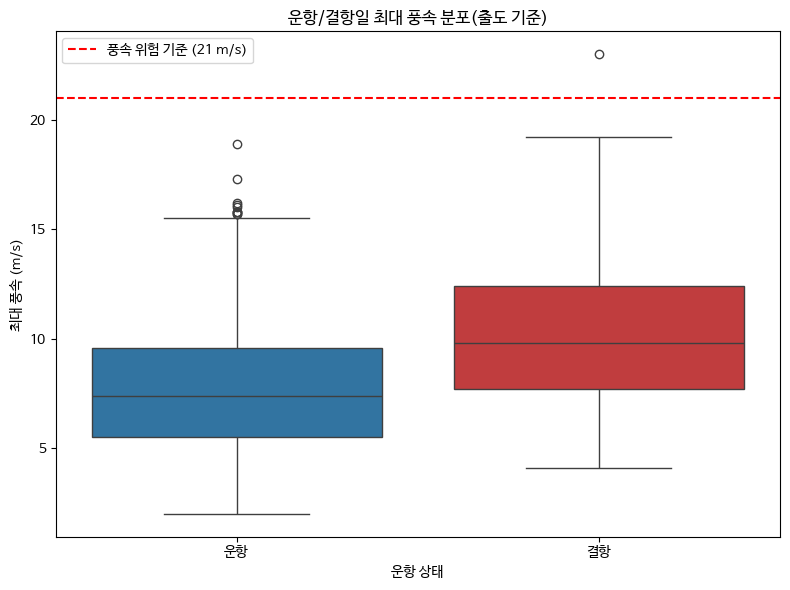

/tmp/ipython-input-2822105008.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


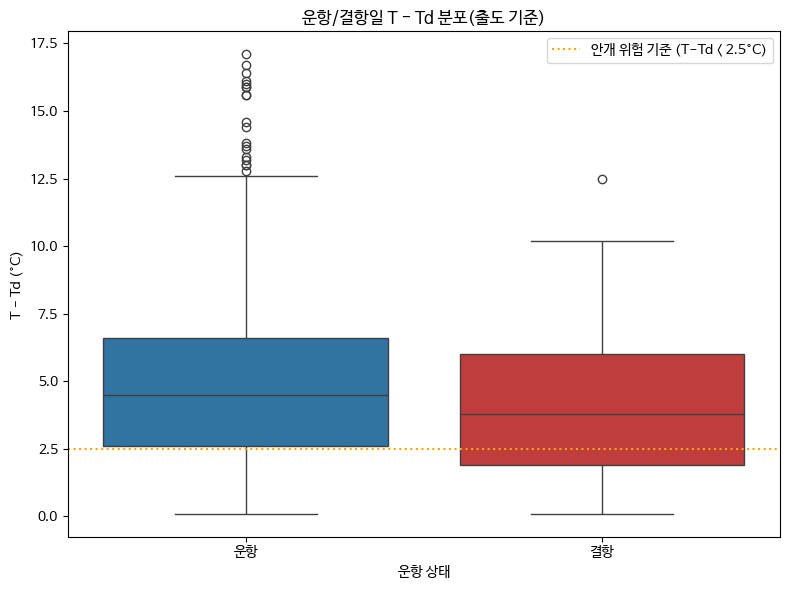

/tmp/ipython-input-2822105008.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


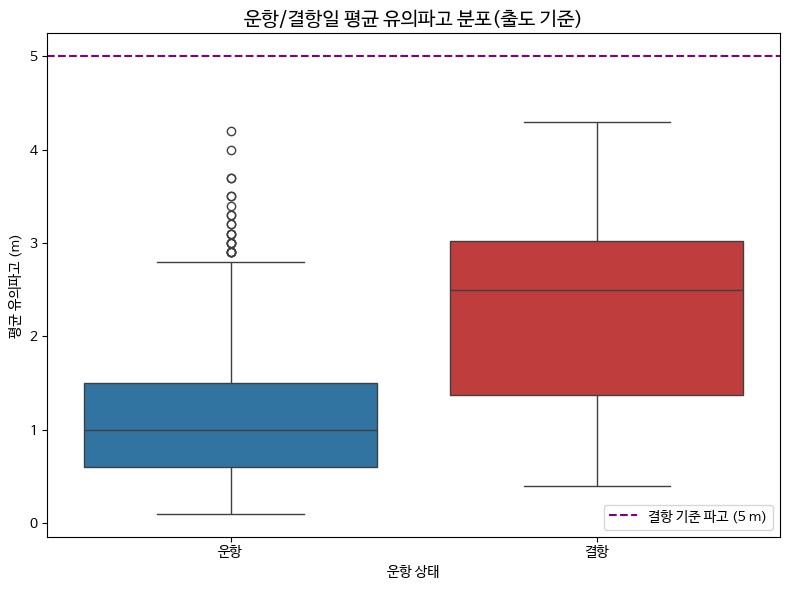

/tmp/ipython-input-2822105008.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


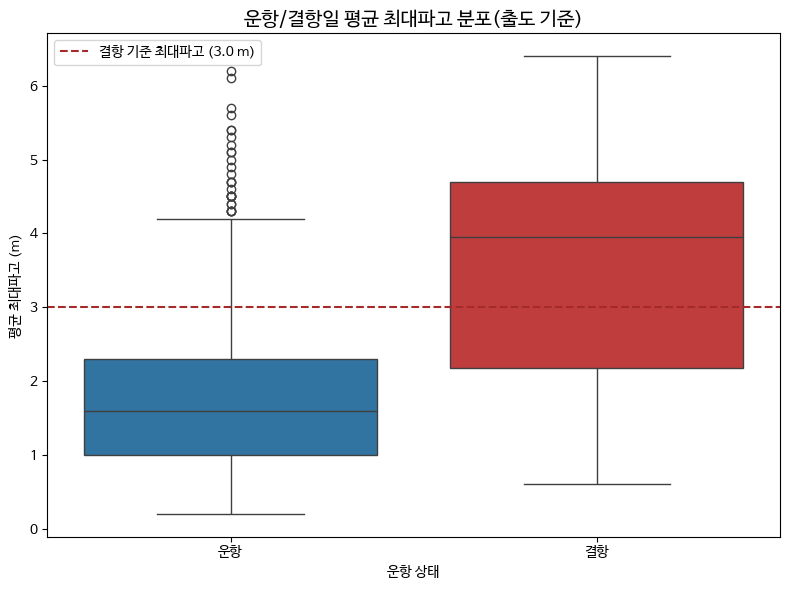

In [63]:
# EDA 시각화

# 최대 풍속
plt.figure(figsize=(8,6))
sns.boxplot(
    x='상태', y='최대풍속', data=df_combined,
    palette={'운항':'#1f77b4','결항':'#d62728'},
    order=['운항','결항']
)
plt.axhline(21, color='red', linestyle='--', label='풍속 위험 기준 (21 m/s)')
plt.title('운항/결항일 최대 풍속 분포(출도 기준)')
plt.xlabel('운항 상태')
plt.ylabel('최대 풍속 (m/s)')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
#  T - Td (안개지표)
plt.figure(figsize=(8,6))
sns.boxplot(
    x='상태', y='T_minus_Td', data=df_combined,
    palette={'운항':'#1f77b4','결항':'#d62728'},
    order=['운항','결항']
)
plt.axhline(2.5, color='orange', linestyle=':', label='안개 위험 기준 (T-Td < 2.5°C)')
plt.title('운항/결항일 T - Td 분포(출도 기준)')
plt.xlabel('운항 상태')
plt.ylabel('T - Td (°C)')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# 유의파고
plt.figure(figsize=(8,6))
sns.boxplot(
    x='상태',
    y='평균 유의 파고(m)',
    data=df_combined,
    palette={'운항':'#1f77b4', '결항':'#d62728'},
    order=['운항','결항']
)
plt.axhline(5, color='purple', linestyle='--', label='결항 기준 파고 (5 m)')
plt.title('운항/결항일 평균 유의파고 분포(출도 기준)', fontsize=14)
plt.xlabel('운항 상태')
plt.ylabel('평균 유의파고 (m)')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
#  최대파고
plt.figure(figsize=(8,6))
sns.boxplot(
    x='상태',
    y='평균 최대 파고(m)',
    data=df_combined,
    palette={'운항':'#1f77b4', '결항':'#d62728'},
    order=['운항','결항']
)
plt.axhline(3.0, color='brown', linestyle='--', label='결항 기준 최대파고 (3.0 m)')
plt.title('운항/결항일 평균 최대파고 분포(출도 기준)', fontsize=14)
plt.xlabel('운항 상태')
plt.ylabel('평균 최대파고 (m)')
plt.legend()
plt.tight_layout()
plt.show()